In [1]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features

import os
import numpy as np
import pandas as pd
from collections import defaultdict
import json
import pg8000


#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



#CellTypesCache will only grab cells that are published to the web
#from allensdk_lims.core.cell_types_cache import CellTypesCache

#allensdk_lims.core.ephys.ephys_features
#allensdk_lims.core.ephys.ephys_extractor
#help(allensdk_lims.ephys.ephys_extractor)

In [2]:
human_df = pd.read_pickle('human_df')
v1_df = pd.read_pickle('v1_df')

In [2]:
new_columns = ['tau','sag','ri','sag_amp','ISI_mean','adaptation_index',
               'capacitance','AP_amp_LS','AP_amp_SS','upstroke_downstroke_ratio','v_rest',
               'rheobase_sweep','ss_latency','ls_latency','instant_sweep','rheobase_i', 
               'hero_rate','fast_trough','hero_sweep','hero_ap_peak_t','hero_ap_threshold_v','IH']

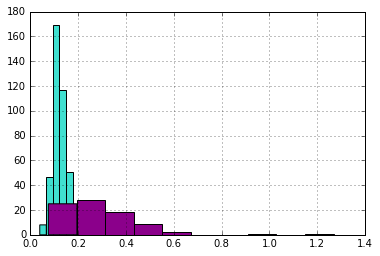

In [21]:
v1_df['capacitance'] = v1_df['tau']/v1_df['ri']
v1_df['capacitance'].hist(color = 'turquoise')
human_df['capacitance'].hist(color = 'darkmagenta')

#plt.scatter( np.arange(0,len(human_df)), human_df['tau']*1000/human_df['ri'],color = 'darkmagenta')


In [22]:
def json_feature_parse(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    path = data['specimens'][0]['cell_ephys_features']
    specimen_id = data['id']
    
    features = []
    tau = path['long_squares']['tau']
    features.append(tau)
    sag = path['long_squares']['sag']
    features.append(sag)
    ri = path['long_squares']['input_resistance']
    features.append(ri)
    sag_amp =path['long_squares']['v_baseline'] - (path['long_squares']['vm_for_sag']*sag)
    features.append(sag_amp)
    ISI_mean = path['long_squares']['hero_sweep']['mean_isi']
    features.append(ISI_mean)
    adaptation_index = path['long_squares']['hero_sweep']['adapt']
    features.append(adaptation_index)
    capacitance = tau/ri*1000
    features.append(capacitance)
    AP_LS_amp = path['long_squares']['hero_sweep']['spikes'][0]['peak_v'] - path['long_squares']['hero_sweep']['spikes'][0]['threshold_v']
    features.append(AP_LS_amp)
    AP_SS_amp = path['short_squares']['mean_spike_0']['peak_v'] - path['short_squares']['mean_spike_0']['threshold_v']
    features.append(AP_SS_amp)
    upstroke_downstroke_ratio = path['long_squares']['rheobase_sweep']['spikes'][0]['upstroke_downstroke_ratio']
    features.append(upstroke_downstroke_ratio)
    v_rest = path['long_squares']['v_baseline']
    features.append(v_rest)
    rheobase_sweep = path['long_squares']['rheobase_sweep']['id']
    features.append(rheobase_sweep)
    ss_latency= path['short_squares']['common_amp_sweeps'][0]['latency']
    features.append(ss_latency)
    ls_latency = path['long_squares']['hero_sweep']['latency']
    features.append(ls_latency)
    instant_sweep = path['short_squares']['common_amp_sweeps'][0]['id']
    features.append(instant_sweep)
    rheobase_i = path['long_squares']['rheobase_i']
    features.append(rheobase_i)
    hero_rate = path['long_squares']['hero_sweep']['avg_rate']
    features.append(hero_rate)
    spikes = path['long_squares']['hero_sweep']['spikes']
    fast_trough = path['long_squares']['hero_sweep']['spikes'][0]['fast_trough_v']
    features.append(fast_trough)
    hero_sweep = path['long_squares']['hero_sweep']['id']
    features.append(hero_sweep)
    hero_ap_peak_t = path['long_squares']['hero_sweep']['spikes'][0]['peak_t']
    features.append(hero_ap_peak_t)
    hero_ap_threshold_v = path['long_squares']['hero_sweep']['spikes'][0]['threshold_v']
    features.append(hero_ap_threshold_v)
    IH = {i['id']:i['stim_amp'] for i in path['long_squares']['subthreshold_membrane_property_sweeps'] }
    features.append(IH)

    return features

In [15]:
def get_spec_name(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%ephys_features.json'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    cur.close()

 

In [16]:
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],SplitLinux[5],''))

In [95]:
np.unique(v1_df['dendrite_type'])

array([u'spiny'], dtype=object)

In [10]:
human_df = pd.read_csv('human_layers.csv')
for heading in new_columns:
    human_df[heading] = None

human_df['json_path'] = None

for i,cell in enumerate(human_df['specimen_name']):
    human_df['json_path'].iloc[i] = str(get_spec_name(cell))
    json_features = json_feature_parse(human_df['json_path'].iloc[i])
    for j, heading in enumerate(new_columns):
        human_df[heading][i] = json_features[j]

human_df.to_pickle('human_df')

In [20]:
sag_list = [488432250,
490259892,
322274121,
325919795]

v1_df['json_path'] = None
v1_df['IH'] = None

for cell in sag_list:
    i = list(v1_df['specimen_id']).index(cell)
    v1_df['json_path'].iloc[i] = str(get_spec_name(v1_df['specimen_name'].iloc[i]))
    with open(v1_df['json_path'].iloc[i], 'r') as f:
        data = json.load(f)
    path = data['specimens'][0]['cell_ephys_features']
    specimen_id = data['id']
    v1_df['hero_sweep'].iloc[i] = path['long_squares']['hero_sweep']['id']
    v1_df['IH'].iloc[i] = [j['id'] for j in path['long_squares']['subthreshold_membrane_property_sweeps'] ]

In [21]:

v1_df['hero_peak_t'] = None
for i, cell in enumerate(v1_df['specimen_name']):
    try:
        v1_df['json_path'].iloc[i] = str(get_spec_name(cell))
        with open(v1_df['json_path'].iloc[i], 'r') as f:
            data = json.load(f)
        path = data['specimens'][0]['cell_ephys_features']
        specimen_id = data['id']
        v1_df['hero_sweep'].iloc[i] = path['long_squares']['hero_sweep']['id']
        v1_df['hero_firing_rate'].iloc[i] = path['long_squares']['hero_sweep']['avg_rate']
        v1_df['hero_peak_t'].iloc[i] = path['long_squares']['hero_sweep']['spikes'][0]['peak_t']
    except TypeError:
        pass

In [43]:
v1_df

adaptation     avg_isi  electrode_0_pa  f_i_curve_slope  \
1      0.032340   55.895000      -55.964379         0.280000   
2      0.162880   59.473000        5.602500         0.091032   
3      0.113440   86.349000       -9.024376         0.204990   
4      0.030623   72.309615       -6.614375         0.251415   
5      0.063797  118.585714      -29.261874         0.184740   
6      0.047695   62.894000      -20.613126         0.162090   
7      0.006833   93.393889     -149.886242         0.172500   
9      0.027348   59.734333       -1.678750         0.214556   
13     0.024410   68.607692      -31.014372         0.210544   
15     0.200068   95.035000      -23.461877         0.085300   
17          NaN         NaN      -44.526875         0.007778   
18          NaN   42.315000      -38.116874         0.048673   
20     0.033843   60.256667        0.081875         0.170279   
23     0.027998   48.113750       10.003750         0.316228   
24     0.015226   85.318000      -19.323125         0.164266   
27     0.299873  108.910000       -4.633125         0.074167   
28     0.150595  121.082500       -6.553750         0.112362   
29     0.097023  129.621667      -10.483126         0.124762   
30     0.025132  128.169167       35.886873         0.088232   
32     0.239483  144.753000        5.268125         0.091720   
33     0.094251   94.870000       20.307500         0.156434   
34          NaN   32.505000      -86.274363         0.146830   
38     0.099119  227.028333       44.947501         0.042740   
39     0.020350   62.870000       -1.768125         0.198165   
44     0.031105   62.496667        2.825000         0.282226   
45     0.117267   67.903333      -46.703749         0.199413   
47     0.025950   79.600000       -4.405000         0.164054   
48     0.023253   86.653636       -8.805625         0.142396   
51     0.050026   47.656750       11.266250         0.215164   
53     0.077184   98.277778       13.154375         0.138987   
..          ...         ...             ...              ...   
765    0.018131   56.161250      -24.265001         0.201399   
766    0.071405  118.105000      -27.031252         0.085417   
768    0.026536   97.820000      -62.933748         0.130357   
771    0.037504   69.601538      -40.838125         0.189546   
773    0.042683   55.804688      -12.468125         0.258199   
774    0.039202   94.519444      -36.572499         0.196793   
775    0.018206   52.890556       -8.875001         0.207784   
776    0.050039   45.904250        9.637500         0.284654   
777         NaN   42.502500       27.355625         0.074902   
778         NaN   26.865000       21.707500         0.057228   
779   -0.003253   82.542727        1.456875         0.192609   
781    0.060675  103.245000       27.077502        -0.015048   
782    0.030695   98.969444        9.190625         0.200700   
786         NaN         NaN        0.019375         0.017742   
787    0.288858  147.790000      -13.231875         0.159756   
789    0.008371  138.005000      -30.640001         0.173458   
790    0.258177  104.791667      -10.133750        -0.007234   
791    0.152611   80.324000       20.596250         0.127816   
792    0.003208   50.372105      -21.737499         0.268548   
793    0.033028   79.263636      -54.984375         0.177320   
795    0.006343   90.144000      -30.894374         0.143931   
797    0.027847  151.652000      -31.707501         0.107445   
798         NaN         NaN      -14.635000         0.114950   
802    0.042215   81.394545       13.653750         0.177449   
804    0.178353   75.043000       12.960625         0.103170   
805    0.010159   61.953000      -10.953750         0.244087   
806    0.031992   55.960313       10.682500         0.229943   
808    0.120391   73.387000      -30.902499         0.102614   
809    0.024827   85.355000      -34.951250         0.212450   
810    0.022992   57.503437       -9.769375         0.245112   

     fast_trough_t_long_square  fast

In [5]:
#check dataframe status
human_df = human_df[human_df['layer'].fillna(0) != 0]
human_df = human_df[human_df['dendrite_type'].fillna(0) != 0]
human_df['dendrite_type'] = 'spiny'
human_df.to_pickle('human_df')

In [33]:
#SQL query from David
query = """
select wkf.storage_directory || wkf.filename as nwb_path, sp.id as specimen_id, sp.name as specimen_name
from well_known_files wkf 
join ephys_roi_results err on wkf.attachable_id = err.id
join specimens sp on sp.ephys_roi_result_id = err.id
where wkf.well_known_file_type_id = 475137571
and err.workflow_state = 'manual_passed'

"""
nwb_files = lu.query(query)
cell_index = { c['specimen_id']: c for c in nwb_files}

nwb_df = pd.DataFrame(nwb_files)

In [31]:
#build up the human_df if starting from scratch


human_df['nwb_path'] = None
for i,cell in enumerate(human_df['specimen_id']):
    try:
        human_df['nwb_path'].iloc[i] = nwb_df.loc[nwb_df['specimen_id'] == cell,'nwb_path'].item()
        human_df['nwb_path'].iloc[i] = lu.linux_to_windows(human_df['nwb_path'].iloc[i])
    except ValueError:
        pass


In [34]:
v1_df['nwb_path'] = None
for i,cell in enumerate(v1_df['specimen_id']):
    try:
        v1_df['nwb_path'].iloc[i] = nwb_df.loc[nwb_df['specimen_id'] == cell,'nwb_path'].item()
        v1_df['nwb_path'].iloc[i] = lu.linux_to_windows(v1_df['nwb_path'].iloc[i])
        v1_df['specimen_name'].iloc[i] = nwb_df.loc[nwb_df['specimen_id'] == cell,'specimen_name'].item()
    except ValueError:
        pass


In [75]:
nwb_df.head()

nwb_path  specimen_id  \
0  /projects/mousecelltypes/vol1/prod115/Ephys_Sp...    313860745   
1  /projects/mousecelltypes/vol1/prod115/Ephys_Sp...    313861369   
2  /projects/mousecelltypes/vol1/prod115/Ephys_Sp...    313861411   
3  /projects/mousecelltypes/vol1/prod115/Ephys_Sp...    313861539   
4  /projects/mousecelltypes/vol1/prod115/Ephys_Sp...    313861608   

                           specimen_name  
0  Rorb-IRES2-Cre-D;Ai14-168047.01.02.01  
1    Pvalb-IRES-Cre;Ai14-165172.05.01.01  
2    Pvalb-IRES-Cre;Ai14-165172.05.02.01  
3    Pvalb-IRES-Cre;Ai14-165171.06.02.01  
4    Pvalb-IRES-Cre;Ai14-165874.04.02.01

In [66]:
#master creation of dataframe. Takes lots of time to go through cell_features
#use pd.read_pickle to upload last saved version since pd.read_csv does not save dictionaries as objects so 'IH' does not work right now

query2 = """
select es.sweep_number, est.description as stimulus_code, estt.name as stimulus_type from ephys_sweeps es
join ephys_stimuli est on es.ephys_stimulus_id = est.id
join ephys_stimulus_types estt on estt.id = est.ephys_stimulus_type_id
where es.specimen_id = """

human_df = pd.read_csv('human_layers.csv')
human_df = human_df[human_df['layer'].fillna(0) != 0]
human_df = human_df[human_df['dendrite_type'].fillna(0) != 0]
human_df['dendrite_type'] = 'spiny'
human_df['nwb_path'] = None
for i,cell in enumerate(human_df['specimen_id']):
    try:
        human_df['nwb_path'].iloc[i] = nwb_df.loc[nwb_df['specimen_id'] == cell,'nwb_path'].item()
    except ValueError:
        pass


new_columns = ['tau','sag','ri','sag_amp','ISI_mean','adaptation_index',
               'capacitance','AP_amp_LS','AP_amp_SS','upstroke_downstroke_ratio','v_rest',
               'rheobase_sweep','ss_latency','ls_latency','instant_sweep','rheobase_i', 
               'noise_1','noise_2','hero_rate','fast_trough','hero_sweep',
               'hero_ap_peak_t','hero_ap_threshold_v','layer','dendrite_type','IH']

columns = list(human_df.columns)
columns.extend(new_columns)
human_df = human_df.reindex(columns = columns)


#human_df = human_df[human_df['nwb_path'].fillna(0) != 0]
for i,cell in enumerate(human_df['specimen_id']):
    file_name = lu.linux_to_windows(human_df['nwb_path'].iloc[i])
    data_set = NwbDataSet(file_name)
    sweeps = lu.query(query2+str(cell))
    sweep_numbers = defaultdict(list)
    for sweep in sweeps:
        sweep_numbers[sweep['stimulus_type']].append(sweep['sweep_number'])

    
    cell_features = extract_cell_features(NwbDataSet(file_name),
                                      sweep_numbers['Ramp'],
                                      sweep_numbers['Short Square'],
                                      sweep_numbers['Long Square'])

    #print cell_features.keys()
    human_df['tau'].iloc[i] = cell_features['long_squares']['tau']
    human_df['sag'].iloc[i] = cell_features['long_squares']['sag']
    human_df['ri'].iloc[i] = cell_features['long_squares']['input_resistance']
    human_df['sag_amp'].iloc[i] = cell_features['long_squares']['v_baseline'] - (cell_features['long_squares']['vm_for_sag']*cell_features['long_squares']['sag'])
    human_df['ISI_mean'].iloc[i] = cell_features['long_squares']['hero_sweep']['mean_isi']
    human_df['adaptation_index'].iloc[i] = cell_features['long_squares']['hero_sweep']['adapt']
    human_df['capacitance'].iloc[i] = cell_features['long_squares']['tau']/cell_features['long_squares']['input_resistance']*1000
    human_df['AP_amp_LS'].iloc[i] = cell_features['long_squares']['hero_sweep']['spikes'][0]['peak_v'] - cell_features['long_squares']['hero_sweep']['spikes'][0]['trough_v']
    human_df['AP_amp_SS'].iloc[i] = cell_features['short_squares']['mean_spike_0']['peak_v'] - cell_features['short_squares']['mean_spike_0']['trough_v']
    human_df['upstroke_downstroke_ratio'].iloc[i] = cell_features['long_squares']['rheobase_sweep']['spikes'][0]['upstroke_downstroke_ratio']
    human_df['v_rest'].iloc[i] = cell_features['long_squares']['v_baseline']
    human_df['rheobase_sweep'].iloc[i] = cell_features['long_squares']['rheobase_sweep']['id']
    human_df['ss_latency'].iloc[i] = cell_features['short_squares']['common_amp_sweeps'][0]['latency']
    human_df['ls_latency'].iloc[i] = cell_features['long_squares']['hero_sweep']['latency']
    human_df['instant_sweep'].iloc[i] = cell_features['short_squares']['common_amp_sweeps'][0]['id']
    human_df['rheobase_i'].iloc[i] = cell_features['long_squares']['rheobase_i']
    try:
        human_df['noise_1'].iloc[i] = sweep_numbers['Noise 1'][0]
        human_df['noise_2'].iloc[i] = sweep_numbers['Noise 2'][0]
    except IndexError:
        pass
    human_df['hero_rate'].iloc[i] = cell_features['long_squares']['hero_sweep']['avg_rate']
    spikes = cell_features['long_squares']['hero_sweep']['spikes']
    if len(spikes) > 1:
        human_df['fast_trough'].iloc[i] = np.mean([spikes[f]['fast_trough_v'] for f in range(len(spikes))])
    else:
        human_df['fast_trough'].iloc[i] = cell_features['long_squares']['hero_sweep']['spikes'][0]['fast_trough_v']
    human_df['hero_sweep'].iloc[i] = cell_features['long_squares']['hero_sweep']['id']
    human_df['hero_ap_peak_t'].iloc[i] = cell_features['long_squares']['hero_sweep']['spikes'][0]['peak_t']
    human_df['hero_ap_threshold_v'].iloc[i] = cell_features['long_squares']['hero_sweep']['spikes'][0]['threshold_v']
    human_df['IH'].iloc[i] = {i['id']:i['stim_amp'] for i in cell_features['long_squares']['subthreshold_membrane_property_sweeps'] }
    
    #print cell
    
human_df['specimen_id'] = human_df['Cell Specimen Id']
human_df['dendrite_type'] = human_df['Cell Type']

FeatureError: Could not find hero sweep.

In [7]:
query2 = """
select es.sweep_number, est.description as stimulus_code, estt.name as stimulus_type from ephys_sweeps es
join ephys_stimuli est on es.ephys_stimulus_id = est.id
join ephys_stimulus_types estt on estt.id = est.ephys_stimulus_type_id
where es.specimen_id = """
i = 0
cell = human_df['specimen_id'].iloc[0]
human_df.nwb_path.iloc[i] = lu.linux_to_windows(human_df.nwb_path.iloc[i])
file_name =  human_df['nwb_path'].iloc[i]
data_set = NwbDataSet(file_name)
sweeps = lu.query(query2+str(cell))
sweep_numbers = defaultdict(list)
for sweep in sweeps:
    sweep_numbers[sweep['stimulus_type']].append(sweep['sweep_number'])


cell_features = extract_cell_features(NwbDataSet(file_name),
                                  sweep_numbers['Ramp'],
                                  sweep_numbers['Short Square'],
                                  sweep_numbers['Long Square'])

In [45]:
human_df.to_pickle('human_df')

# Start Diving into the Features

# Let's bring the mouse into this

In [4]:
#import the v1 data as a dataframe and include some of the metadata

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.core.cell_types_cache import ReporterStatus as RS
from allensdk.ephys.feature_extractor import EphysFeatureExtractor


ctc = CellTypesCache()
ephys_features = ctc.get_ephys_features()
cells = ctc.get_cells()
cell_index = {c['id']: c for c in cells}


v1_df = pd.DataFrame(data=ephys_features)
v1_df['cre_line'], v1_df['cre_reporter'],v1_df['location'] = None, None, None
v1_df['specimen_name'], v1_df['hero_firing_rate'], v1_df['json_path'] = None, None, None
v1_df['ephys_roi_result_id'] = None
v1_df['dendrite_type'],v1_df['depth'] = None, None
for i, spec_id in enumerate(v1_df['specimen_id']):
    v1_df['cre_line'][i] = cell_index[spec_id]['transgenic_line']
    v1_df['cre_reporter'][i] = cell_index[spec_id]['cell_reporter']['name']
    v1_df['dendrite_type'][i] = cell_index[spec_id]['dendrite_type']
    v1_df['depth'][i] = cell_index[spec_id]['cell_soma_locations'][0]['normalized_depth']
v1_df = v1_df[v1_df['dendrite_type'] == 'spiny']

In [10]:
custom_report = pd.read_csv('custom_report.csv')
v1_df['apical'] = None
v1_df['structure'] = None
for i, cell in enumerate(v1_df['specimen_id']):
    v1_df['apical'].iloc[i] = custom_report.loc[custom_report['cell_specimen_id'] == cell, 'apical'].item()
    v1_df['structure'].iloc[i] = custom_report.loc[custom_report['cell_specimen_id'] == cell, 'structure'].item()
    if 'intact' in v1_df['apical'].iloc[i]:
        v1_df['apical'].iloc[i] = 'intact'
    if 'truncated' in v1_df['apical'].iloc[i]:
        v1_df['apical'].iloc[i] = 'truncated'
    v1_df['location'].iloc[i] = v1_df['structure'].iloc[i][-1]
    if v1_df['structure'].iloc[i][-1] == 'a' or v1_df['structure'].iloc[i][-1] == 'b':
        v1_df['location'].iloc[i] = v1_df['structure'].iloc[i][-2]

In [29]:
v1_df.to_pickle('v1_df')

([<matplotlib.axis.XTick at 0x10c12ac8>,
 <a list of 6 Text xticklabel objects>)

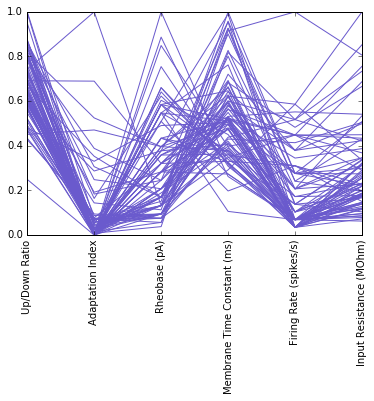

In [12]:
#normalized to max values for each category

color = {'aspiny':'lime','spiny':'slateblue'}

for i in range(len(human_df)):
    plt.plot(np.arange(0,6),[human_df['upstroke_downstroke_ratio'].iloc[i]/np.max(human_df['upstroke_downstroke_ratio']),
                             human_df['adaptation_index'].fillna(0).iloc[i]/np.max(human_df['adaptation_index']),
                             human_df['rheobase_i'].iloc[i]/np.max(human_df['rheobase_i']),
                             human_df['tau'].iloc[i]/np.max(human_df['tau']),
                             human_df['hero_rate'].iloc[i]/np.max(human_df['hero_rate']),
                             human_df['ri'].iloc[i]/np.max(human_df['ri'])], color = color[human_df['dendrite_type'].iloc[i]] )
plt.xticks(np.arange(0,6),['Up/Down Ratio','Adaptation Index','Rheobase (pA)','Membrane Time Constant (ms)','Firing Rate (spikes/s)','Input Resistance (MOhm)'],
           rotation = 'vertical')
        


In [24]:
v1_df

adaptation     avg_isi  electrode_0_pa  f_i_curve_slope  \
1      0.032340   55.895000      -55.964379         0.280000   
2      0.162880   59.473000        5.602500         0.091032   
3      0.113440   86.349000       -9.024376         0.204990   
4      0.030623   72.309615       -6.614375         0.251415   
5      0.063797  118.585714      -29.261874         0.184740   
6      0.047695   62.894000      -20.613126         0.162090   
7      0.006833   93.393889     -149.886242         0.172500   
9      0.027348   59.734333       -1.678750         0.214556   
13     0.024410   68.607692      -31.014372         0.210544   
15     0.200068   95.035000      -23.461877         0.085300   
17          NaN         NaN      -44.526875         0.007778   
18          NaN   42.315000      -38.116874         0.048673   
20     0.033843   60.256667        0.081875         0.170279   
23     0.027998   48.113750       10.003750         0.316228   
24     0.015226   85.318000      -19.323125         0.164266   
27     0.299873  108.910000       -4.633125         0.074167   
28     0.150595  121.082500       -6.553750         0.112362   
29     0.097023  129.621667      -10.483126         0.124762   
30     0.025132  128.169167       35.886873         0.088232   
32     0.239483  144.753000        5.268125         0.091720   
33     0.094251   94.870000       20.307500         0.156434   
34          NaN   32.505000      -86.274363         0.146830   
38     0.099119  227.028333       44.947501         0.042740   
39     0.020350   62.870000       -1.768125         0.198165   
44     0.031105   62.496667        2.825000         0.282226   
45     0.117267   67.903333      -46.703749         0.199413   
47     0.025950   79.600000       -4.405000         0.164054   
48     0.023253   86.653636       -8.805625         0.142396   
51     0.050026   47.656750       11.266250         0.215164   
53     0.077184   98.277778       13.154375         0.138987   
..          ...         ...             ...              ...   
765    0.018131   56.161250      -24.265001         0.201399   
766    0.071405  118.105000      -27.031252         0.085417   
768    0.026536   97.820000      -62.933748         0.130357   
771    0.037504   69.601538      -40.838125         0.189546   
773    0.042683   55.804688      -12.468125         0.258199   
774    0.039202   94.519444      -36.572499         0.196793   
775    0.018206   52.890556       -8.875001         0.207784   
776    0.050039   45.904250        9.637500         0.284654   
777         NaN   42.502500       27.355625         0.074902   
778         NaN   26.865000       21.707500         0.057228   
779   -0.003253   82.542727        1.456875         0.192609   
781    0.060675  103.245000       27.077502        -0.015048   
782    0.030695   98.969444        9.190625         0.200700   
786         NaN         NaN        0.019375         0.017742   
787    0.288858  147.790000      -13.231875         0.159756   
789    0.008371  138.005000      -30.640001         0.173458   
790    0.258177  104.791667      -10.133750        -0.007234   
791    0.152611   80.324000       20.596250         0.127816   
792    0.003208   50.372105      -21.737499         0.268548   
793    0.033028   79.263636      -54.984375         0.177320   
795    0.006343   90.144000      -30.894374         0.143931   
797    0.027847  151.652000      -31.707501         0.107445   
798         NaN         NaN      -14.635000         0.114950   
802    0.042215   81.394545       13.653750         0.177449   
804    0.178353   75.043000       12.960625         0.103170   
805    0.010159   61.953000      -10.953750         0.244087   
806    0.031992   55.960313       10.682500         0.229943   
808    0.120391   73.387000      -30.902499         0.102614   
809    0.024827   85.355000      -34.951250         0.212450   
810    0.022992   57.503437       -9.769375         0.245112   

     fast_trough_t_long_square  fast

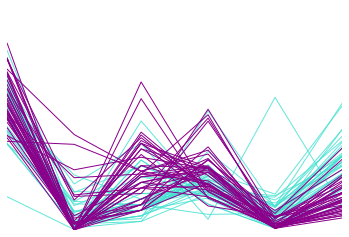

In [98]:
#normalized to values on celltypes.brain-map.org

color = {'mouse':{'aspiny':'goldenrod','spiny':'turquoise','sparsely spiny':'goldenrod'},
         'human':{'aspiny':'tomato','spiny':'darkmagenta'}}

#plt.rcParams['axes.facecolor'] = 'black'
for i in range(len(v1_df)):
    if v1_df['location'].iloc[i] == '3':
        plt.plot(np.arange(0,6),[v1_df['upstroke_downstroke_ratio_long_square'].iloc[i]/6,
                             (v1_df['adaptation'].fillna(0).iloc[i]/1.2+(1/6)),
                             v1_df['threshold_i_long_square'].iloc[i]/800,
                             v1_df['tau'].iloc[i]/100,
                             v1_df['hero_firing_rate'].fillna(0).iloc[i]/150,
                             v1_df['ri'].iloc[i]/600], color = color['mouse'][v1_df['dendrite_type'].iloc[i]],alpha = .8)
for i in range(len(human_df)):
    if human_df['layer'].iloc[i] >= 1 and human_df['layer'].iloc[i] <=3:
        plt.plot(np.arange(0,6),[human_df['upstroke_downstroke_ratio'].iloc[i]/6,
                             (human_df['adaptation_index'].fillna(0).iloc[i]/1.2+(1/6)),
                             human_df['rheobase_i'].iloc[i]/800,
                             human_df['tau'].iloc[i]/.100,
                             human_df['hero_rate'].iloc[i]/150,
                             human_df['ri'].iloc[i]/600], color = color['human'][human_df['dendrite_type'].iloc[i]])
        
#plt.xticks(np.arange(0,6),['Up/Down Ratio','Adaptation Index','Rheobase (pA)','Membrane Time Constant (ms)','Firing Rate (spikes/s)','Input Resistance (MOhm)'],
           #rotation = 'vertical')
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.axis('off')
#plt.rcParams['axes.facecolor'] = 'black'
plt.savefig('chart.png')

In [29]:
cell_color_dict = {'Cux2-CreERT2':'greenyellow',
 'Nr5a1-Cre':'darkcyan',
 'Scnn1a-Tg2-Cre':'turquoise',
 'Slc17a6-IRES-Cre':'navajowhite',
 'Scnn1a-Tg3-Cre':'aqua',
 'Rorb-IRES2-Cre':'aquamarine',
 'Rbp4-Cre_KL100':'forestgreen',
 'Ctgf-2A-dgCre':'indigo',
    'Ntsr1-Cre':'cyan',
 'Ntsr1-Cre_GN220':'cyan',
 'Gad2-IRES-Cre':'darkred',
 'Htr3a-Cre_NO152':'saddlebrown',
 'Pvalb-IRES-Cre':'crimson',
 'Sst-IRES-Cre': 'orange',
 'Vip-IRES-Cre': 'fuchsia'}
cell_color_list_v1 = [cell_color_dict[i] for i in v1_df['cre_line']]
color = {'aspiny':'lime','spiny':'slateblue'}
cell_color_list_human = [color[i] for i in human_df['dendrite_type']]

In [13]:
np.unique(v1_df['location'])

array(['3', '4', '5', '6'], dtype=object)

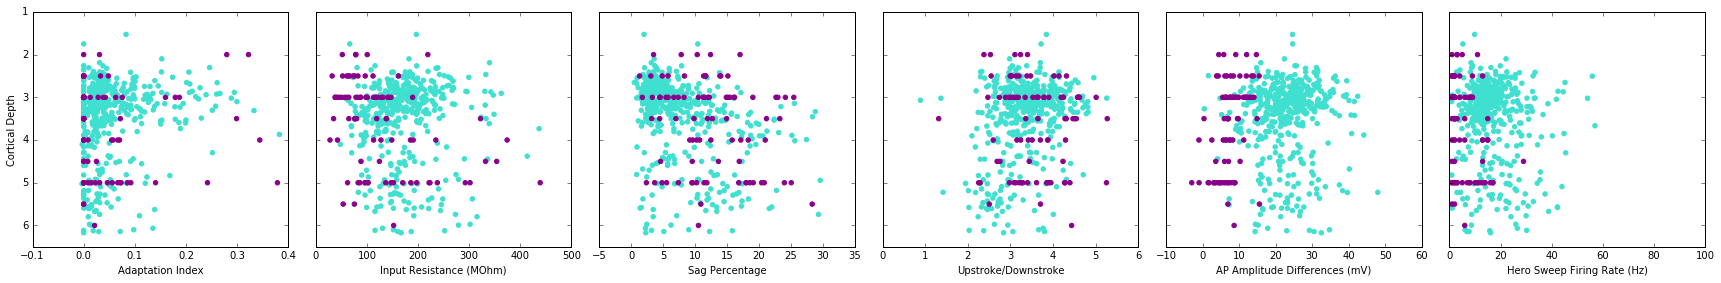

In [14]:
#break down features by layer depth

fig,axes = plt.subplots(1,6,figsize=(24,4),sharey= True)

color1= {'mouse':{'aspiny':'goldenrod','spiny':'turquoise','sparsely spiny':'goldenrod'},'human':{'aspiny':'tomato','spiny':'darkmagenta'}}
cell_color_list_v1 = [color1['mouse'][i] for i in v1_df['dendrite_type']]
cell_color_list_human = [color1['human'][i] for i in human_df['dendrite_type']]

axes[0].scatter(v1_df['adaptation'].fillna(0),v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[0].scatter(human_df['adaptation_index'].fillna(0),human_df['layer'],color = cell_color_list_human)
axes[0].set_xlabel('Adaptation Index')
axes[0].set_ylabel('Cortical Depth')
axes[0].set_xlim(-.1,.4)
axes[0].set_ylim(1,6.5)
axes[0].invert_yaxis()

axes[1].scatter(v1_df['ri'],v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[1].scatter(human_df['ri'],human_df['layer'], color = cell_color_list_human)
axes[1].set_xlabel('Input Resistance (MOhm)')

axes[2].scatter(v1_df['sag']*100,v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[2].scatter(human_df['sag']*100, human_df['layer'],color = cell_color_list_human)
axes[2].set_xlabel('Sag Percentage')

axes[3].scatter(v1_df['upstroke_downstroke_ratio_long_square'],v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[3].scatter(human_df['upstroke_downstroke_ratio'], human_df['layer'],color = cell_color_list_human)
axes[3].set_xlabel('Upstroke/Downstroke')

v1_ap_amp = [v1_df['peak_v_short_square'].iloc[i] - v1_df['trough_v_short_square'].iloc[i]  - v1_df['peak_v_long_square'].iloc[i]  + v1_df['trough_v_long_square'].iloc[i] for i in range(len(v1_df))] 
axes[4].scatter(v1_ap_amp,v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[4].scatter(human_df['AP_amp_SS'] - human_df['AP_amp_LS'], human_df['layer'],color = cell_color_list_human)
axes[4].set_xlabel('AP Amplitude Differences (mV)')

v1_rate = [v1_df['f_i_curve_slope'].iloc[i] * (v1_df['threshold_i_long_square'].iloc[i]) for i in range(len(v1_df))]
axes[5].scatter(v1_rate,v1_df['depth']*5.2+1,color = cell_color_list_v1)
axes[5].scatter(human_df['hero_rate'], human_df['layer'],color = cell_color_list_human)
axes[5].set_xlabel('Hero Sweep Firing Rate (Hz)')
axes[5].set_xlim(0,100)


plt.tight_layout()

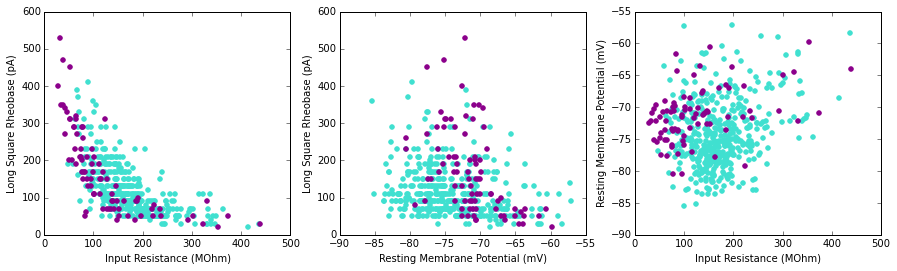

In [51]:
fig,axes = plt.subplots(1,3,figsize=(15,4))

axes[0].scatter(v1_df['ri'],v1_df['threshold_i_long_square'], color = 'turquoise')
axes[0].scatter(human_df['ri'],human_df['rheobase_i'], color = 'darkmagenta')
axes[0].set_ylabel('Long Square Rheobase (pA)')
axes[0].set_xlabel('Input Resistance (MOhm)')
axes[0].set_ylim(0,600)

axes[1].scatter(v1_df['vrest'],v1_df['threshold_i_long_square'], color = 'turquoise')
axes[1].scatter(human_df['v_rest'],human_df['rheobase_i'], color = 'darkmagenta')
axes[1].set_ylabel('Long Square Rheobase (pA)')
axes[1].set_xlabel('Resting Membrane Potential (mV)')
axes[1].set_ylim(0,600)

axes[2].scatter(v1_df['ri'],v1_df['vrest'], color = 'turquoise')
axes[2].scatter(human_df['ri'],human_df['v_rest'], color = 'darkmagenta')
axes[2].set_ylabel('Resting Membrane Potential (mV)')
axes[2].set_xlabel('Input Resistance (MOhm)')
fig,axes = plt.subplots(1,3,figsize=(15,4))

axes[0].scatter(v1_df['ri'],v1_df['threshold_i_long_square'], color = 'turquoise')
axes[0].scatter(human_df['ri'],human_df['rheobase_i'], color = 'darkmagenta')
axes[0].set_ylabel('Long Square Rheobase (pA)')
axes[0].set_xlabel('Input Resistance (MOhm)')
axes[0].set_ylim(0,600)

axes[1].scatter(v1_df['vrest'],v1_df['threshold_i_long_square'], color = 'turquoise')
axes[1].scatter(human_df['v_rest'],human_df['rheobase_i'], color = 'darkmagenta')
axes[1].set_ylabel('Long Square Rheobase (pA)')
axes[1].set_xlabel('Resting Membrane Potential (mV)')
axes[1].set_ylim(0,600)

axes[2].scatter(v1_df['ri'],v1_df['vrest'], color = 'turquoise')
axes[2].scatter(human_df['ri'],human_df['v_rest'], color = 'darkmagenta')
axes[2].set_ylabel('Resting Membrane Potential (mV)')
axes[2].set_xlabel('Input Resistance (MOhm)')

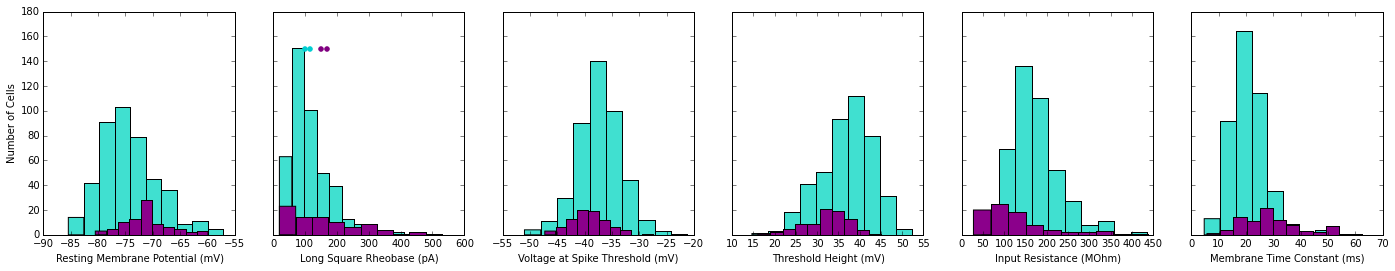

In [113]:
fig,axes = plt.subplots(1,6,figsize=(24,4),sharey = True)

axes[0].hist(np.hstack(v1_df['vrest']),color = 'turquoise')
axes[0].hist(np.hstack(human_df['v_rest']),color = 'darkmagenta')
axes[0].set_ylabel('Number of Cells')
axes[0].set_xlabel('Resting Membrane Potential (mV)')

axes[1].hist(np.hstack(v1_df['threshold_i_long_square']),color = 'turquoise')
axes[1].hist(np.hstack(human_df['rheobase_i']),color = 'darkmagenta')
#axes[1].set_ylabel('Number of Cells')
axes[1].set_xlabel('Long Square Rheobase (pA)')
axes[1].scatter([np.mean(v1_df['threshold_i_long_square']),np.median(v1_df['threshold_i_long_square'])],[150,150], color = 'darkturquoise',zorder = 20)
axes[1].scatter([np.mean(human_df['rheobase_i']),np.median(human_df['rheobase_i'])],[150,150], color = 'purple',zorder = 20)
axes[1].set_xlim(0,600)

axes[2].hist(np.hstack(v1_df['threshold_v_long_square']),color = 'turquoise')
axes[2].hist(np.hstack(human_df['hero_ap_threshold_v']),color = 'darkmagenta')
#axes[2].set_ylabel('Number of Cells')
axes[2].set_xlabel('Voltage at Spike Threshold (mV)')

axes[4].hist(np.hstack(v1_df['ri']),color = 'turquoise')
axes[4].hist(np.hstack(human_df['ri']),color = 'darkmagenta')
#axes[4].set_ylabel('Number of Cells')
axes[4].set_xlabel('Input Resistance (MOhm)')

axes[3].hist(np.hstack(v1_df['threshold_v_long_square']-v1_df['vrest']),color = 'turquoise')
axes[3].hist(np.hstack(human_df['hero_ap_threshold_v']-human_df['v_rest']),color = 'darkmagenta')
#axes[3].set_ylabel('Number of Cells')
axes[3].set_xlabel('Threshold Height (mV)')

axes[5].hist(np.hstack(v1_df['tau']),color = 'turquoise')
axes[5].hist(np.hstack(human_df['tau']*1000),color = 'darkmagenta')
#axes[5].set_ylabel('Number of Cells')
axes[5].set_xlabel('Membrane Time Constant (ms)')

(0, 180)

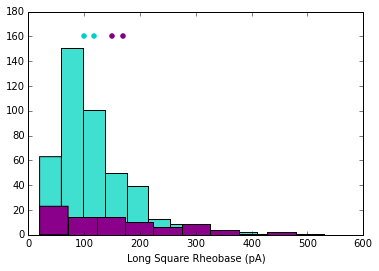

In [117]:
plt.hist(np.hstack(v1_df['threshold_i_long_square']),color = 'turquoise')
plt.hist(np.hstack(human_df['rheobase_i']),color = 'darkmagenta')
#axes[1].set_ylabel('Number of Cells')
plt.xlabel('Long Square Rheobase (pA)')
plt.scatter([np.mean(v1_df['threshold_i_long_square']),np.median(v1_df['threshold_i_long_square'])],[160,160], color = 'darkturquoise',zorder = 20)
plt.scatter([np.mean(human_df['rheobase_i']),np.median(human_df['rheobase_i'])],[160,160], color = 'purple',zorder = 20)
plt.xlim(0,600)
plt.ylim(0,180)

In [106]:
print np.mean(v1_df['threshold_i_long_square'])
print np.median(v1_df['threshold_i_long_square'])

print np.mean(human_df['rheobase_i'])
print np.median(human_df['rheobase_i'])

117.356321401
100.0
168.571428117
150.0


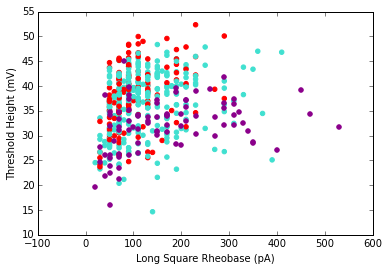

In [34]:
#Use this to normalize the RMP out of the view
apical_color = {'intact': 'turquoise', 'truncated': 'red','apical - NA':'turquoise'}
apical_color_list = [apical_color[v1_df['apical'].iloc[i]] for i in range(len(v1_df))]
plt.scatter(v1_df['threshold_i_long_square'],v1_df['threshold_v_long_square']-v1_df['vrest'], color = apical_color_list)
plt.scatter(human_df['rheobase_i'], human_df['hero_ap_threshold_v']-human_df['v_rest'], color = 'darkmagenta')
plt.xlabel('Long Square Rheobase (pA)')
plt.ylabel('Threshold Height (mV)')
#plt.ylim(0,600)

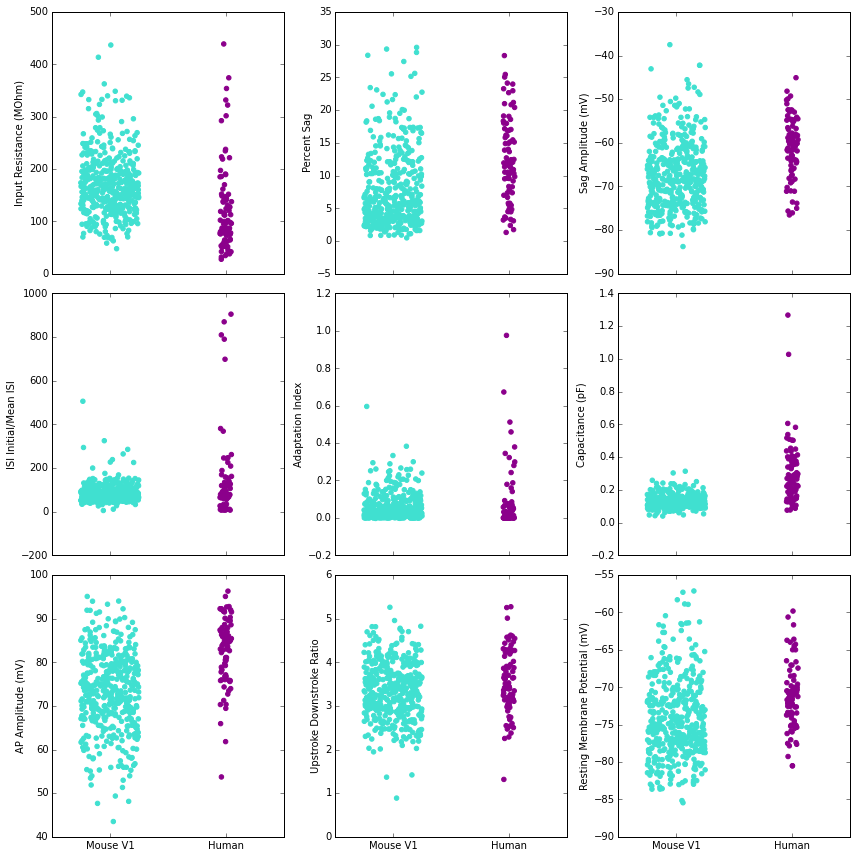

In [123]:
#set up jitter on the AIBS dataset
x0 = np.random.rand(len(v1_df))*.5-.25
x1 = np.random.rand(len(human_df))*.1+.95

fig,axes = plt.subplots(3,3,figsize=(12,12), sharex=True)

axes[0,0].scatter(x0,v1_df['ri'],color = cell_color_list_v1)
axes[0,0].scatter(x1,human_df['ri'], color = cell_color_list_human)
axes[0,0].set_xticks([0,1])
axes[0,0].set_xticklabels(['Mouse V1','Human'])
axes[0,0].set_ylabel('Input Resistance (MOhm)')
axes[0,0].set_xlim(-.5,1.5)

axes[0,1].scatter(x0,v1_df['sag']*100,color = cell_color_list_v1)
axes[0,1].scatter(x1,human_df['sag']*100, color = cell_color_list_human)
axes[0,1].set_xticks([0,1])
axes[0,1].set_xticklabels(['AIBS','Kim'])
axes[0,1].set_ylabel('Percent Sag')
axes[0,1].set_xlim(-.5,1.5)

v1_sag_amp = [v1_df['vrest'].iloc[i] - (v1_df['vm_for_sag'].iloc[i]*v1_df['sag'].iloc[i]) for i in range(len(v1_df))]
axes[0,2].scatter(x0,v1_sag_amp,color = cell_color_list_v1)
axes[0,2].scatter(x1,human_df['sag_amp'], color = cell_color_list_human)
axes[0,2].set_xticks([0,1])
axes[0,2].set_xticklabels(['Mouse V1','Human'])
axes[0,2].set_ylabel('Sag Amplitude (mV)')
axes[0,2].set_xlim(-.5,1.5)

axes[1,0].scatter(x0,v1_df['avg_isi'],color = cell_color_list_v1)
axes[1,0].scatter(x1,human_df['ISI_mean']*1000, color = cell_color_list_human)
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(['Mouse V1','Human'])
axes[1,0].set_ylabel('ISI Initial/Mean ISI')
axes[1,0].set_xlim(-.5,1.5)

axes[1,1].scatter(x0,v1_df['adaptation'].fillna(0),color = cell_color_list_v1)
axes[1,1].scatter(x1,human_df['adaptation_index'].fillna(0), color = cell_color_list_human)
axes[1,1].set_xticks([0,1])
axes[1,1].set_xticklabels(['Mouse V1','Human'])
axes[1,1].set_ylabel('Adaptation Index')
axes[1,1].set_xlim(-.5,1.5)

axes[1,2].scatter(x0,v1_df['tau']/v1_df['ri'],color = cell_color_list_v1)
axes[1,2].scatter(x1,human_df['capacitance'], color = cell_color_list_human)
axes[1,2].set_xticks([0,1])
axes[1,2].set_xticklabels(['Mouse V1','Human'])
axes[1,2].set_ylabel('Capacitance (pF)')
axes[1,2].set_xlim(-.5,1.5)

v1_ap_amp =[v1_df['peak_v_long_square'].iloc[i] - v1_df['threshold_v_long_square'].iloc[i] for i in range(len(v1_df))]
axes[2,0].scatter(x0,v1_ap_amp,color = cell_color_list_v1)
axes[2,0].scatter(x1,human_df['AP_amp_LS'], color = cell_color_list_human)
axes[2,0].set_xticks([0,1])
axes[2,0].set_xticklabels(['Mouse V1','Human'])
axes[2,0].set_ylabel('AP Amplitude (mV)')
axes[2,0].set_xlim(-.5,1.5)


axes[2,1].scatter(x0,v1_df['upstroke_downstroke_ratio_long_square'],color = cell_color_list_v1)
axes[2,1].scatter(x1,human_df['upstroke_downstroke_ratio'], color = cell_color_list_human)
axes[2,1].set_xticks([])
axes[2,1].set_xticklabels(['Mouse V1','Human'])
axes[2,1].set_ylabel('Upstroke Downstroke Ratio')
axes[2,1].set_xlim(-.5,1.5)

axes[2,2].scatter(x0,v1_df['vrest'],color = cell_color_list_v1)
axes[2,2].scatter(x1,human_df['v_rest'], color = cell_color_list_human)
axes[2,2].set_xticks([0,1])
axes[2,2].set_xticklabels(['Mouse V1','Human'])
axes[2,2].set_ylabel('Resting Membrane Potential (mV)')
axes[2,2].set_xlim(-.5,1.5)

plt.tight_layout()

In [42]:
v1_df.columns

Index([u'adaptation', u'avg_isi', u'electrode_0_pa', u'f_i_curve_slope', u'fast_trough_t_long_square', u'fast_trough_t_ramp', u'fast_trough_t_short_square', u'fast_trough_v_long_square', u'fast_trough_v_ramp', u'fast_trough_v_short_square', u'has_burst', u'has_delay', u'has_pause', u'id', u'input_resistance_mohm', u'latency', u'peak_t_long_square', u'peak_t_ramp', u'peak_t_short_square', u'peak_v_long_square', u'peak_v_ramp', u'peak_v_short_square', u'rheobase_sweep_id', u'rheobase_sweep_number', u'ri', u'sag', u'seal_gohm', u'slow_trough_t_long_square', u'slow_trough_t_ramp', u'slow_trough_t_short_square', u'slow_trough_v_long_square', u'slow_trough_v_ramp', u'slow_trough_v_short_square', u'specimen_id', u'tau', u'threshold_i_long_square', u'threshold_i_ramp', u'threshold_i_short_square', u'threshold_t_long_square', u'threshold_t_ramp', u'threshold_t_short_square', u'threshold_v_long_square', u'threshold_v_ramp', u'threshold_v_short_square', u'thumbnail_sweep_id', u'trough_t_long_squa

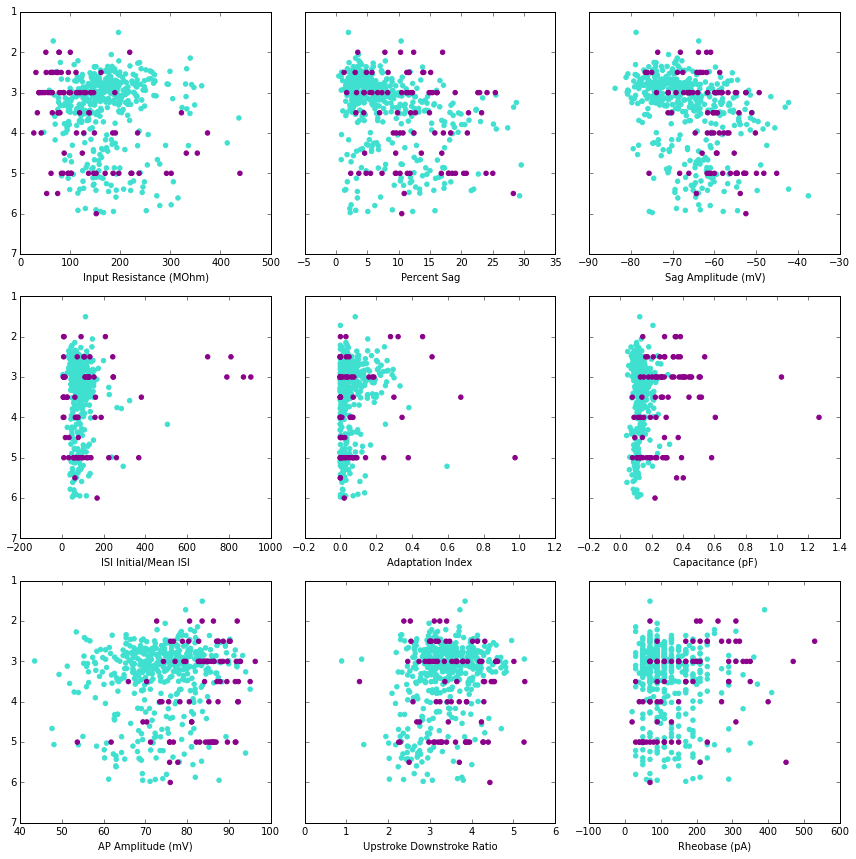

In [122]:
#break down features by layer depth

fig,axes = plt.subplots(3,3,figsize=(12,12),sharey= True)

color1= {'mouse':{'aspiny':'goldenrod','spiny':'turquoise','sparsely spiny':'goldenrod'},'human':{'aspiny':'red','spiny':'darkmagenta'}}
cell_color_list_v1 = [color1['mouse'][i] for i in v1_df['dendrite_type']]
cell_color_list_human = [color1['human'][i] for i in human_df['dendrite_type']]

axes[0,0].scatter(v1_df['ri'],v1_df['depth']*5+1,color = cell_color_list_v1)
axes[0,0].scatter(human_df['ri'],human_df['layer'],color = cell_color_list_human)
axes[0,0].set_xlabel('Input Resistance (MOhm)')
axes[0,0].invert_yaxis()

axes[0,1].scatter(v1_df['sag']*100,v1_df['depth']*5+1,color = cell_color_list_v1)
axes[0,1].scatter(human_df['sag']*100,human_df['layer'], color = cell_color_list_human)
axes[0,1].set_xlabel('Percent Sag')

v1_sag_amp = [v1_df['vrest'].iloc[i] - (v1_df['vm_for_sag'].iloc[i]*v1_df['sag'].iloc[i]) for i in range(len(v1_df))]
axes[0,2].scatter(v1_sag_amp,v1_df['depth']*5+1,color = cell_color_list_v1)
axes[0,2].scatter(human_df['sag_amp'], human_df['layer'],color = cell_color_list_human)
axes[0,2].set_xlabel('Sag Amplitude (mV)')

axes[1,0].scatter(v1_df['avg_isi'],v1_df['depth']*5+1,color = cell_color_list_v1)
axes[1,0].scatter(human_df['ISI_mean']*1000, human_df['layer'],color = cell_color_list_human)
axes[1,0].set_xlabel('ISI Initial/Mean ISI')

axes[1,1].scatter(v1_df['adaptation'].fillna(0),v1_df['depth']*5+1,color = cell_color_list_v1)
axes[1,1].scatter(human_df['adaptation_index'].fillna(0), human_df['layer'],color = cell_color_list_human)
axes[1,1].set_xlabel('Adaptation Index')

axes[1,2].scatter(v1_df['tau']/v1_df['ri'],v1_df['depth']*5+1,color = cell_color_list_v1)
axes[1,2].scatter(human_df['capacitance'], human_df['layer'],color = cell_color_list_human)
axes[1,2].set_xlabel('Capacitance (pF)')

v1_ap_amp =[v1_df['peak_v_long_square'].iloc[i] - v1_df['threshold_v_long_square'].iloc[i] for i in range(len(v1_df))]
axes[2,0].scatter(v1_ap_amp,v1_df['depth']*5+1,color = cell_color_list_v1)
axes[2,0].scatter(human_df['AP_amp_LS'],human_df['layer'], color = cell_color_list_human)
axes[2,0].set_xlabel('AP Amplitude (mV)')

axes[2,1].scatter(v1_df['upstroke_downstroke_ratio_long_square'],v1_df['depth']*5+1,color = cell_color_list_v1)
axes[2,1].scatter(human_df['upstroke_downstroke_ratio'],human_df['layer'],color = cell_color_list_human)
axes[2,1].set_xlabel('Upstroke Downstroke Ratio')

axes[2,2].scatter(v1_df['threshold_i_long_square'],v1_df['depth']*5+1,color = cell_color_list_v1)
axes[2,2].scatter(human_df['rheobase_i'], human_df['layer'],color = cell_color_list_human)
axes[2,2].set_xlabel('Rheobase (pA)')

plt.tight_layout()

#How do these cells fire?

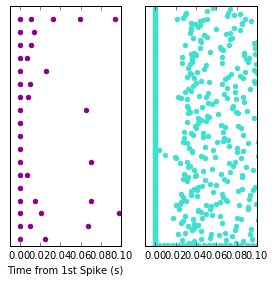

In [124]:
sort_human = human_df[human_df['layer'] >= 3.5]
sort_human = sort_human[sort_human['layer'] < 4.5]
sort_human = sort_human.sort(['upstroke_downstroke_ratio'])
fig,axes = plt.subplots(1,2,figsize=(4,4))
for i,cell in enumerate(sort_human['specimen_id']):
    file_name =  sort_human['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    #color = {'aspiny':'lime','spiny':'slateblue'}
    try:
        x1 = data_set.get_spike_times(sort_human['hero_sweep'].iloc[i])
        axes[0].scatter(x1-x1[0],np.ones(len(x1))*i,color = 'darkmagenta')
    except TypeError:
        pass
    axes[0].set_xlim(-.01,.1)
    #axes[0].set_xticks(rotation = 'vertical'])
    axes[0].set_ylim(-.5,len(sort_human))
    #plt.title('Hero Sweep')
    axes[0].set_xlabel('Time from 1st Spike (s)')
    
sort_mouse = v1_df[v1_df['location'] == '4']
#sort_mouse = sort_mouse[sort_mouse['layer'] <= 4.5]
sort_mouse = sort_mouse.sort(['upstroke_downstroke_ratio_long_square'])
for i,cell in enumerate(sort_mouse['specimen_id']):
    file_name =  sort_mouse['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    #color = {'aspiny':'lime','spiny':'slateblue'}
    try:
        x1 = data_set.get_spike_times(sort_mouse['hero_sweep'].iloc[i])
        axes[1].scatter(x1-x1[0],np.ones(len(x1))*i,color = 'turquoise')
    except TypeError:
        pass
    axes[1].set_xlim(-.01,.1)
    axes[1].set_ylim(-.5,len(sort_mouse))
    axes[1].set_yticks([])
    axes[0].set_yticks([])
plt.tight_layout()
plt.savefig('spike_times.png')

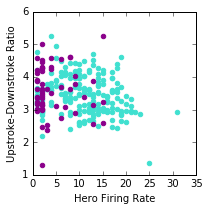

In [115]:
sort_human = human_df[human_df['layer'] >= 3.5]
sort_human = human_df[human_df['layer'] < 4.5]

sort_mouse = v1_df
sort_mouse['layer'] = [float(i) for i in sort_mouse['location']]
sort_mouse = sort_mouse[sort_mouse['layer'] == 4]
plt.figure(figsize = (3,3))
plt.scatter(sort_mouse['hero_firing_rate'],sort_mouse['upstroke_downstroke_ratio_long_square'], color = 'turquoise')
plt.scatter(sort_human['hero_rate'],sort_human['upstroke_downstroke_ratio'], color = 'darkmagenta')
plt.xlabel('Hero Firing Rate')
plt.ylabel('Upstroke-Downstroke Ratio')
plt.xlim(0,35)
plt.tight_layout()
plt.savefig('tau.png')


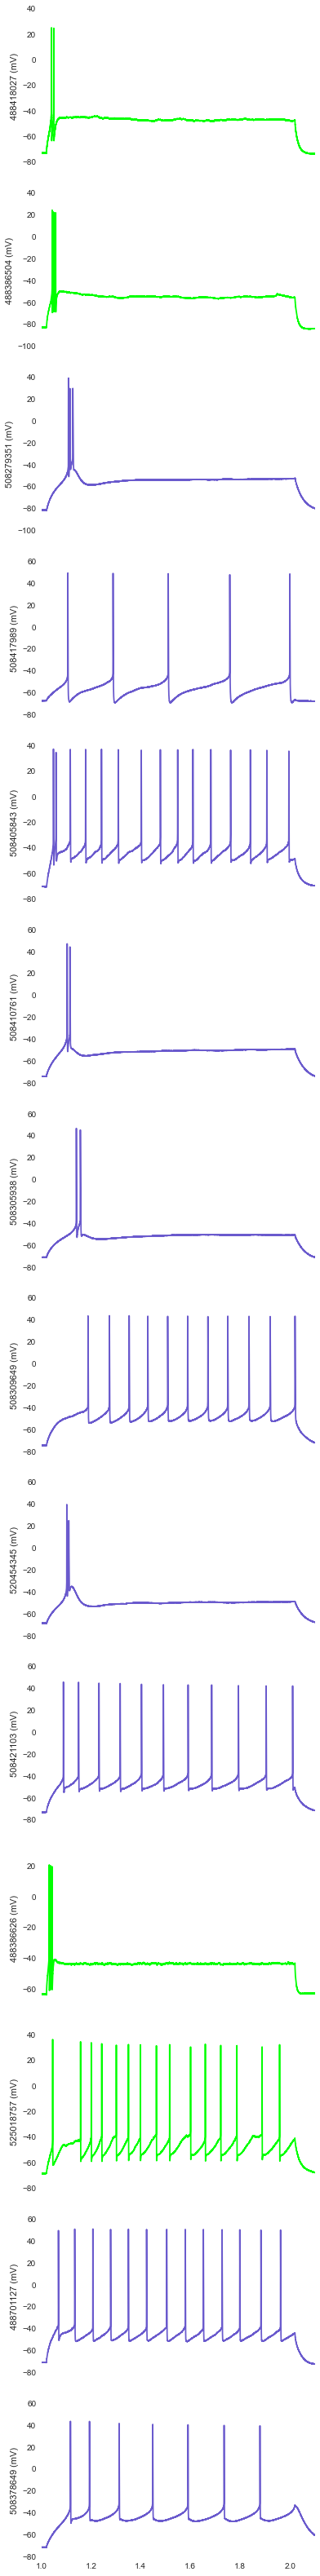

In [28]:
cells_from_rachel = [488418027,488386504,508279351,508417989,508405843,508410761,508305938,508309649,520454345,
                     508421103,488386626,525018757,488701127,508378649]
fig,axes = plt.subplots(len(cells_from_rachel),1,figsize = (6,4*len(cells_from_rachel)),sharex=True)
for i, cell in enumerate(cells_from_rachel):
    file_name = human_df.loc[human_df['specimen_id'] == cell,'nwb_path'].item()
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(human_df.loc[human_df['specimen_id'] == cell,'hero_sweep'].item())
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    axes[i].plot(np.arange(0,len(response))/sampling_rate,response*1000, color = color[human_df.loc[human_df['specimen_id'] == cell,'dendrite_type'].item()])
    axes[i].set_xlim(1,2.1)
    axes[i].set_ylabel(str(cell)+ ' (mV)')
    


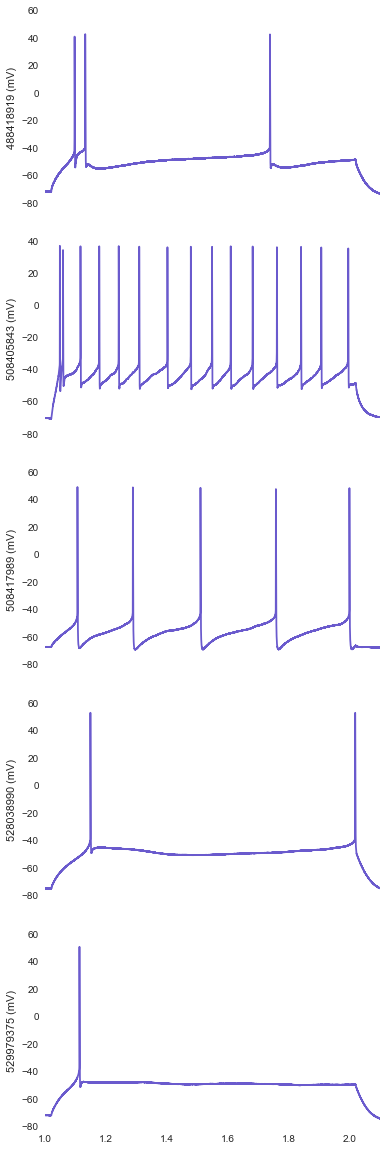

In [15]:
outliers = [488418919,508405843,508417989,528038990,529979375]
fig,axes = plt.subplots(len(outliers),1,figsize = (6,4*len(outliers)),sharex=True)
for i, cell in enumerate(outliers):
    file_name = human_df.loc[human_df['specimen_id'] == cell,'nwb_path'].item()
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(human_df.loc[human_df['specimen_id'] == cell,'hero_sweep'].item())
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    axes[i].plot(np.arange(0,len(response))/sampling_rate,response*1000, color = color[human_df.loc[human_df['specimen_id'] == cell,'dendrite_type'].item()])
    axes[i].set_xlim(1,2.1)
    axes[i].set_ylabel(str(cell)+ ' (mV)')

#We now have layers so let's start looking at layer specific properties

In [22]:
human_df.groupby(['layer']).size()

layer
2.0     5
2.5    11
3.0    24
3.5     9
4.0     9
4.5     4
5.0    19
5.5     2
6.0     1
dtype: int64

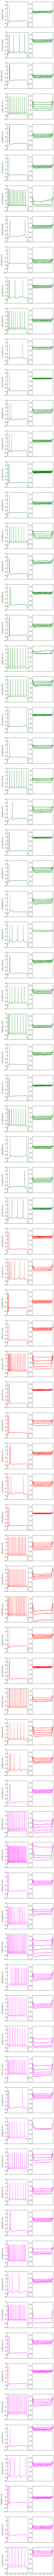

In [113]:
layer_colors = {2.0: 'green', 2.5: 'green', 3.0: 'green', 
                3.5: 'red', 4.0: 'red', 
                4.5: 'magenta', 5.0: 'magenta', 5.5: 'magenta', 6: 'magenta'}
layer_df = human_df.sort('layer')
fig,axes = plt.subplots(len(layer_df),2,figsize = (6,4*len(layer_df)),sharex=True)
for i, cell in enumerate(layer_df['specimen_id']):
    file_name = layer_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(layer_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    axes[i,0].plot(np.arange(0,len(response))/sampling_rate,response*1000, color = layer_colors[layer_df['layer'].iloc[i]])
    axes[i,0].set_xlim(1,2.1)
    axes[i,0].set_ylabel(str(cell)+ ' (mV)')
    for ih in layer_df['IH'].iloc[i].keys():
        sweep_data = data_set.get_sweep(ih)
        sampling_rate = sweep_data['sampling_rate']
        response = sweep_data['response']
        axes[i,1].plot(np.arange(0,len(response))/sampling_rate,response*1000,color = layer_colors[layer_df['layer'].iloc[i]])
        axes[i,1].set_xlim(1,2.1)
        axes[i,1].set_ylim(-110,-55)
        #axes[i].set_ylabel(str(cell)+ ' (mV)')

In [43]:
print len(human_df[human_df['layer'] == 3.0])
print len(np.unique(human_df['layer']))

17
7


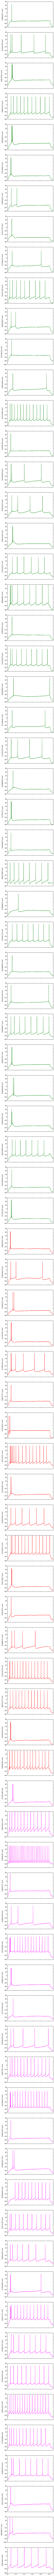

In [10]:
human_df = human_df.sort('layer')
layer_df = human_df[human_df['dendrite_type'] == 'spiny']
layer_colors = {2.0: 'green', 2.5: 'green', 3.0: 'green', 
                3.5: 'red', 4.0: 'red', 
                4.5: 'magenta', 5.0: 'magenta', 5.5: 'magenta', 6: 'magenta'}
fig,axes = plt.subplots(len(layer_df),1,sharex = True,figsize = (6,4*len(layer_df)))
for i, cell in enumerate(layer_df['specimen_id']):
    file_name = layer_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(layer_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    axes[i].plot(np.arange(0,len(response))/sampling_rate,response*1000, color = layer_colors[layer_df['layer'].iloc[i]])
    axes[i].set_xlim(1,2.1)
    axes[i].set_ylabel(str(cell)+ ' (mV)')

In [48]:
doublet_mice = [488698341,479722622,488689403,488688374,488697163,480718588,490576429,485934207,477930684,480003970,487664663]

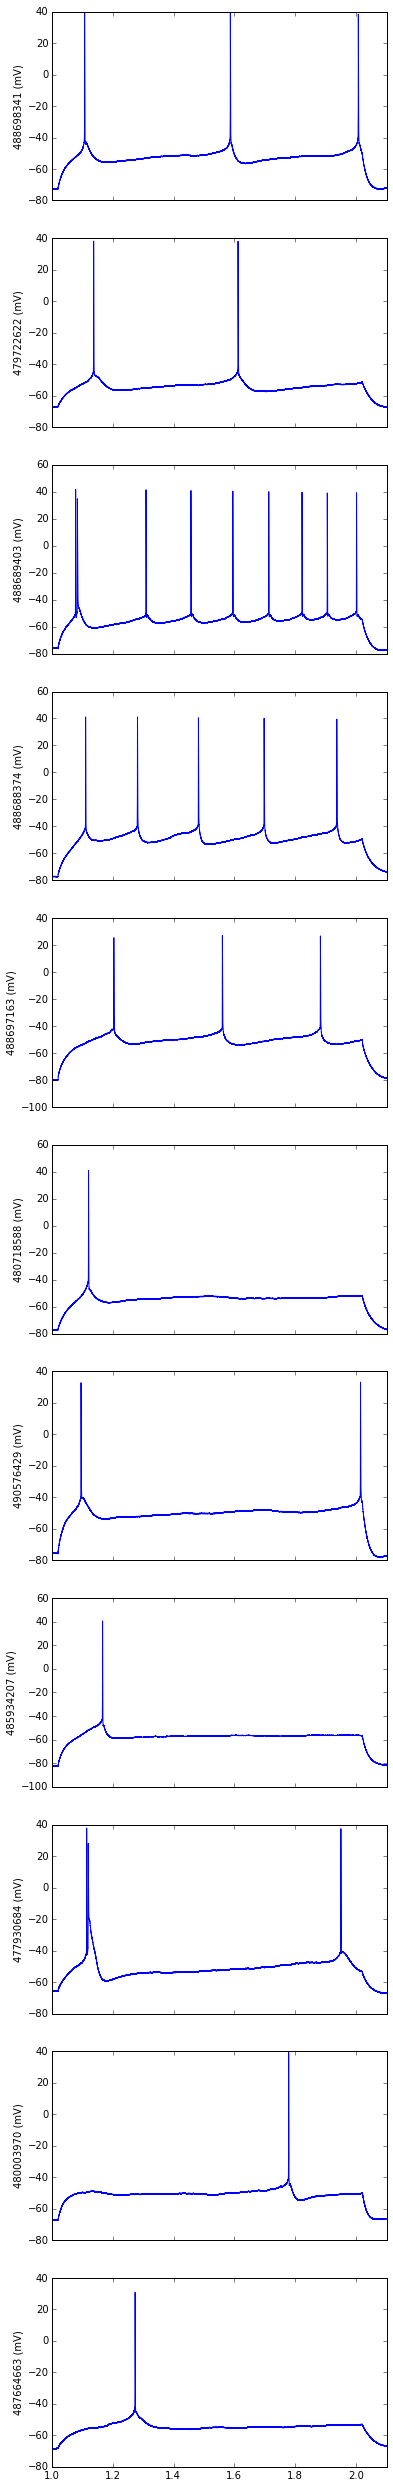

In [49]:
fig,axes = plt.subplots(len(doublet_mice),1,sharex = True,figsize = (6,4*len(doublet_mice)))
for j,cell in enumerate(doublet_mice):
    try:
        data_set = ctc.get_ephys_data(cell)
        sweep_data = data_set.get_sweep(v1_df.loc[v1_df['specimen_id'] == cell,'rheobase_sweep_number'].item())

        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        i *= 1e12 # to pA
        v *= 1e3 # to mV

        sampling_rate = sweep_data["sampling_rate"] # in Hz
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        axes[j].plot(t,v)
        axes[j].set_xlim(1,2.1)
        axes[j].set_ylabel(str(cell)+ ' (mV)')
    except Exception:
        print cell


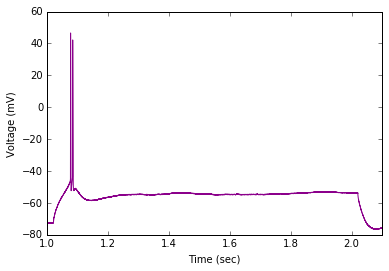

In [89]:
layer_df = human_df[human_df['specimen_id'] == 539556162]
file_name = layer_df['nwb_path'].iloc[0]
data_set = NwbDataSet(file_name)
sweep_data = data_set.get_sweep(layer_df['hero_sweep'].iloc[0])

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.plot(t,v, color = 'darkmagenta')
plt.xlim(1,2.1)
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.savefig('doublet.png')

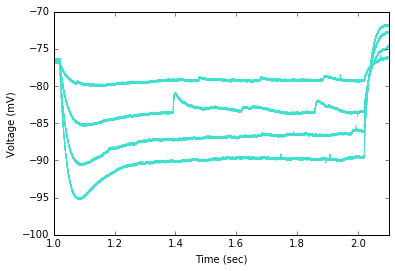

In [27]:
layer_df = v1_df[v1_df['specimen_id'] == sag_list[3]]
file_name = layer_df['nwb_path'].iloc[0]
data_set = NwbDataSet(file_name)


for ih in layer_df['IH'].iloc[0]:
    sweep_data = data_set.get_sweep(ih)
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    plt.plot(np.arange(0,len(response))/sampling_rate,response*1000,color = 'turquoise')
    plt.xlim(1,2.1)
    plt.xlabel('Time (sec)')
    plt.ylabel('Voltage (mV)')
    #plt.ylim(-110,-55)
    #axes[i].set_ylabel(str(cell)+ ' (mV)')
plt.savefig('sag.png')

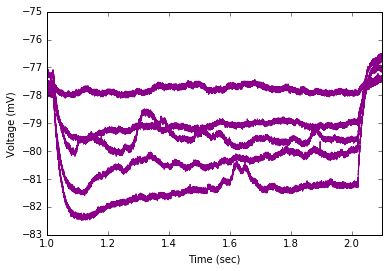

In [54]:
layer_colors = {2.0: 'green', 2.5: 'green', 3.0: 'green', 
                3.5: 'red', 4.0: 'red', 
                4.5: 'magenta', 5.0: 'magenta', 5.5: 'magenta', 6: 'magenta'}

layer_df = human_df[human_df['specimen_id'] == 508280017]
file_name = layer_df['nwb_path'].iloc[0]
data_set = NwbDataSet(file_name)
sweep_data = data_set.get_sweep(layer_df['hero_sweep'].iloc[0])
sampling_rate = sweep_data['sampling_rate']
response = sweep_data['response']

for ih in layer_df['IH'].iloc[0].keys():
    sweep_data = data_set.get_sweep(ih)
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']
    plt.plot(np.arange(0,len(response))/sampling_rate,response*1000,color = 'darkmagenta')
    plt.xlim(1,2.1)
    plt.xlabel('Time (sec)')
    plt.ylabel('Voltage (mV)')
    #plt.ylim(-110,-55)
    #axes[i].set_ylabel(str(cell)+ ' (mV)')
plt.savefig('sag.png')

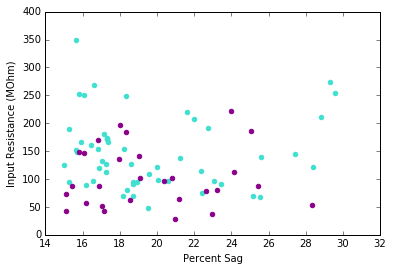

In [128]:
v1_sag = v1_df[v1_df['sag'] >= .15]
human_sag = human_df[human_df['sag'] >= .15]

plt.scatter(v1_sag['sag']*100,v1_sag['ri'],color = 'turquoise')
plt.scatter(human_sag['sag']*100,human_sag['ri'],color = 'darkmagenta')

plt.xlabel('Percent Sag')
plt.ylabel('Input Resistance (MOhm)')
plt.savefig('more_sag.png')

# FI Curves for beginning of long squares

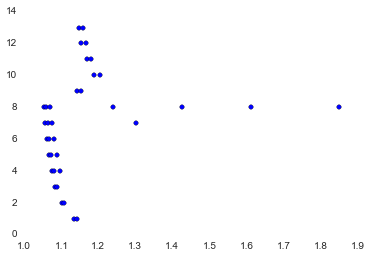

In [42]:
#is this better represented as a roster plot or a curve?

cell_id = 520454345

query2 = """
select es.sweep_number, est.description as stimulus_code, estt.name as stimulus_type from ephys_sweeps es
join ephys_stimuli est on es.ephys_stimulus_id = est.id
join ephys_stimulus_types estt on estt.id = est.ephys_stimulus_type_id
where es.specimen_id = """

file_name = human_df.loc[human_df['specimen_id'] == cell_id,'nwb_path'].item()
data_set = NwbDataSet(file_name)    
sweeps = lu.query(query2+str(cell_id))
sweep_numbers = defaultdict(list)
y=0
for sweep in sweeps:
    sweep_numbers[sweep['stimulus_type']].append(sweep['sweep_number'])
for ls in sorted(sweep_numbers['Long Square']):
    spike_times = data_set.get_spike_times(ls)
    if spike_times != []:
        plt.scatter(spike_times,np.ones(len(spike_times))+y)
        y += 1

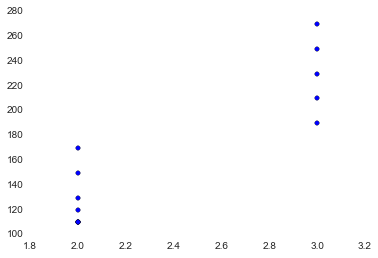

In [17]:
cell_id = 520454345

query2 = """
select es.sweep_number, est.description as stimulus_code, estt.name as stimulus_type from ephys_sweeps es
join ephys_stimuli est on es.ephys_stimulus_id = est.id
join ephys_stimulus_types estt on estt.id = est.ephys_stimulus_type_id
where es.specimen_id = """

file_name = human_df.loc[human_df['specimen_id'] == cell_id,'nwb_path'].item()
data_set = NwbDataSet(file_name)    
sweeps = lu.query(query2+str(cell_id))
sweep_numbers = defaultdict(list)
y=0
for sweep in sweeps:
    sweep_numbers[sweep['stimulus_type']].append(sweep['sweep_number'])
for ls in sorted(sweep_numbers['Long Square']):
    spike_times = data_set.get_spike_times(ls)
    s_spike_times = [s for s in spike_times if s <= 1.22]
    if s_spike_times != []:
        current = data_set.get_sweep(ls)['stimulus'][data_set.get_sweep(ls)['sampling_rate']*1.5]*10**12
        plt.scatter(len(s_spike_times),current)

In [18]:
print data_set.get_sweep(ls)['sampling_rate']
print data_set.get_sweep(ls)['stimulus'][data_set.get_sweep(ls)['sampling_rate']*1.5]*10**12
print data_set.get_sweep(ls)['index_range'][1]/data_set.get_sweep(ls)['sampling_rate']

50000.0
110.000002163
6.01998


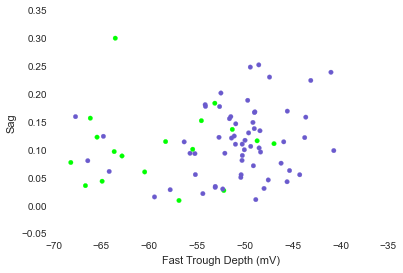

In [14]:
plt.scatter(human_df['fast_trough'],human_df['sag'], color = cell_color_list_human)
plt.ylabel('Sag')
plt.xlabel('Fast Trough Depth (mV)')

(0, 0.25)

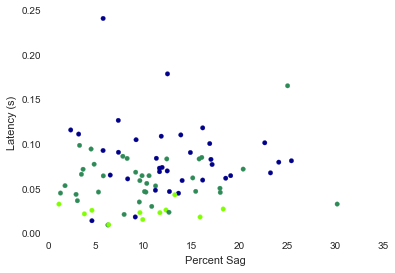

In [36]:
freq_color = {1:'red',2:'orange',3:'yellow'}
freq_rate = []
for i,rate in enumerate(human_df['hero_rate']):
    if rate <= 2:
        freq_rate.append('darkblue')
    if rate >2 and rate < 15:
        freq_rate.append('seagreen')
    if rate >= 15:
        freq_rate.append('chartreuse')
    
plt.scatter(human_df['sag']*100,human_df['ls_latency'], color = freq_rate)
plt.ylabel('Latency (s)')
plt.xlabel('Percent Sag')
plt.xlim(0,35)
plt.ylim(0,.25)

In [37]:
query = """
SELECT sp.id, sp.name,sp.ephys_roi_result_id, cr.name, entt.name as neural_tissue_template,
ts.name as tcp_sop,str.acronym as structure,csl.normalized_depth 
FROM specimens sp 
JOIN ephys_specimen_roi_plans esrp ON sp.parent_id = esrp.specimen_id 
JOIN ephys_roi_plans erp ON esrp.ephys_roi_plan_id = erp.id 
JOIN ephys_neural_tissue_plans entp ON esrp.ephys_neural_tissue_plan_id = entp.id 
JOIN task_templates entt ON entp.ephys_neural_tissue_template_id = entt.id AND entt.type = 'EphysNeuralTissueTemplate' 
JOIN tissue_processings tp ON entp.id = tp.ephys_neural_tissue_plan_id 
JOIN task_templates tpt ON tp.tissue_processing_template_id = tpt.id AND tpt.type = 'TissueProcessingTemplate' 
JOIN tcp_sops ts ON tpt.tcp_sop_id = ts.id 
JOIN ephys_roi_results err ON sp.ephys_roi_result_id = err.id 
LEFT JOIN cell_reporters cr ON sp.cell_reporter_id = cr.id 
LEFT JOIN structures str ON sp.structure_id = str.id 
LEFT JOIN cell_soma_locations csl ON csl.specimen_id = sp.id 
WHERE err.workflow_state = 'manual_passed'
"""
other_df = lu.query(query)

In [178]:
#can we extract the features from swc?
import allensdk.core.swc as swc

path = '/projects/humancelltypes/vol1/prod55/specimen_520454345/H16.03.002.01.06.01_549379618_m.swc'
file_name = lu.linux_to_windows(path)
morphology = swc.read_swc(file_name)

# subsample the morphology 3x. root, soma, junctions, and the first child of the root are preserved.
sparse_morphology = morphology.sparsify(3)

# compartments in the order that they were specified in the file
compartment_list = sparse_morphology.compartment_list

# a dictionary of compartments indexed by compartment id
compartments_by_id = sparse_morphology.compartment_index

# the root soma compartment 
soma = morphology.soma

# all compartments are dictionaries of compartment properties
# compartments also keep track of ids of their children
for child in morphology.children_of(soma):
    print(child['x'], child['y'], child['z'], child['radius'])


(379.5506, 1082.0181, 17.92, 0.4576)
(385.3175, 1086.2257, 22.7511, 0.4576)
(382.8202, 1086.2783, 27.2275, 0.572)
(380.3731, 1083.8439, 26.2167, 0.4576)
(380.571, 1083.5179, 34.0488, 0.4576)
(385.5543, 1070.5987, 27.8816, 0.8008)
(391.4551, 1082.105, 29.1015, 0.4576)
(389.6281, 1083.956, 35.2811, 0.1144)


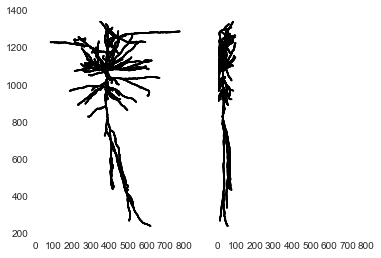

In [183]:
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box-forced')
axes[1].set_aspect('equal', 'box-forced')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

'''
# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]

axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]

axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
'''
plt.show()

# PLOS Paper figures
http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002007

In [144]:
freq_color = {'spiny':{1:'red',2:'orange',3:'yellow'},'aspiny':{1:'mediumblue',2:'teal',3:'mediumseagreen'}}
freq_color['spiny'][1]

'red'

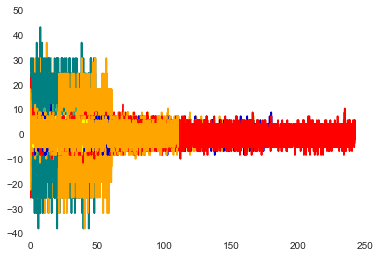

In [58]:
#what does the first derivative of current onset to the peak of the first spike look like?
import scipy.signal as signal
for i in range(len(human_df)):
    file_name = human_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(human_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']

    if human_df['hero_rate'].iloc[i] == 1:
        freq = 1
    if human_df['hero_rate'].iloc[i] >1 and human_df['hero_rate'].iloc[i] < 15:
        freq = 2
    if human_df['hero_rate'].iloc[i] >= 15:
        freq = 3
    dendrite = human_df['dendrite_type'].iloc[i]
    if dendrite == 'spiny':
        j = 0
    if dendrite == 'aspiny':
        j = 1
    
    spike_times = data_set.get_spike_times(human_df['hero_sweep'].iloc[i])

    dv = np.diff(response[1.02*sampling_rate:spike_times[0]*sampling_rate])
    plt.plot(np.arange(len(dv))*1000/sampling_rate,dv*sampling_rate,color = freq_color[dendrite][freq])

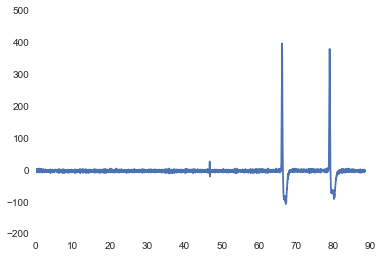

In [52]:
peak_t = human_df['hero_ap_peak_t'].iloc[i]
response = sweep_data['response']
response = response[1.02*sampling_rate:peak_t*sampling_rate]
dv = np.diff(response)
plt.plot(np.arange(len(dv))*1000/sampling_rate,dv*sampling_rate)

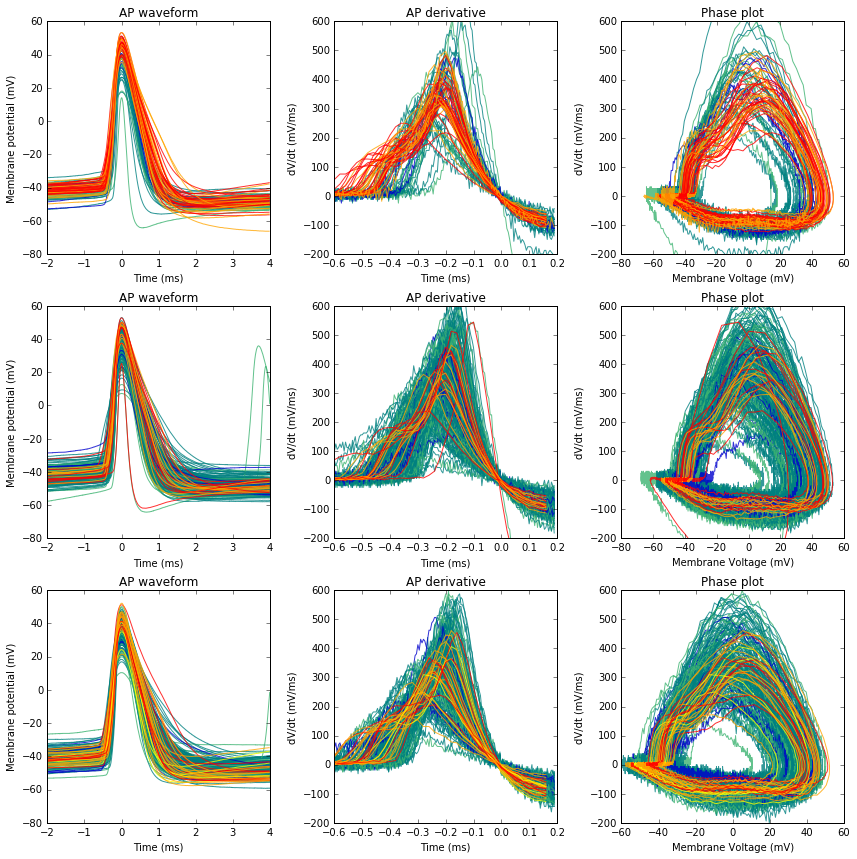

In [31]:
freq_color = {'human':{1:'red',2:'orange',3:'yellow'},'mouse':{1:'mediumblue',2:'teal',3:'mediumseagreen'}}
import scipy.signal as signal
fig,axes = plt.subplots(3,3,figsize = (12,12))
'''
for i in range(len(human_df)):
    file_name = human_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(human_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']

    if human_df['hero_rate'].iloc[i] <= 2:
        freq = 1
    if human_df['hero_rate'].iloc[i] >2 and human_df['hero_rate'].iloc[i] <= 15:
        freq = 2
    if human_df['hero_rate'].iloc[i] > 15:
        freq = 3
    if human_df['layer'].iloc[i] <= 3:
        j = 0
    if human_df['layer'].iloc[i] == 3.5 or human_df['layer'].iloc[i] == 4:
        j = 1
    if human_df['layer'].iloc[i] >= 4.5:
        j = 2
    
    
    peak_t = human_df['hero_ap_peak_t'].iloc[i]
    spike_times = data_set.get_spike_times(human_df['hero_sweep'].iloc[i])
    
    #AP Waveform
    start = (peak_t - .002) * sampling_rate
    end = (peak_t + .004) * sampling_rate
    ap_wave = response[start:end]
    axes[j,0].plot(np.arange(-(len(ap_wave)/3),2*len(ap_wave)/3)*1000/sampling_rate,ap_wave*1000,color = freq_color['human'][freq], alpha = .8)
    axes[j,0].set_xlabel('Time (ms)')
    axes[j,0].set_ylabel('Membrane potential (mV)')
    axes[j,0].set_title('AP waveform')
    axes[j,0].set_ylim(-80,60)
    
    #AP derivative
    N = 4
    Wn = .1

    B,A = signal.butter(N, Wn, output = 'ba')
    
    peak_t = human_df['hero_ap_peak_t'].iloc[i]
    ap_deriv = response[(peak_t-.0006)*sampling_rate:(peak_t+.0002)*sampling_rate]

    dv = np.diff(ap_deriv)
    dv_f = signal.filtfilt(B,A,dv)
    #plt.plot(np.arange(0,len(ap_deriv)-1),dv*sampling_rate,color = 'black')
    axes[j,1].plot(np.arange(-(len(ap_deriv)*3/4),len(ap_deriv)/4-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color['human'][freq], alpha = .8)

    #axes[1].plot(np.arange(0,len(ap_deriv)-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color[freq], alpha = .6)
    axes[j,1].set_xlabel('Time (ms)')
    axes[j,1].set_ylabel('dV/dt (mV/ms)')
    axes[j,1].set_title('AP derivative')
    axes[j,1].set_ylim(-200,600)
    
    #Phase plot
    phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
    dv = np.diff(phase_plot)
    dv_f = signal.filtfilt(B,A,dv)
    axes[j,2].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color['human'][freq], alpha = .8)
    #plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
    axes[j,2].set_xlabel('Membrane Voltage (mV)')
    axes[j,2].set_ylabel('dV/dt (mV/ms)')
    axes[j,2].set_title('Phase plot')
    axes[j,2].set_ylim(-200,600)

    
    #Inital portion of phase plot
    phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
    dv = np.diff(phase_plot)
    dv_f = signal.filtfilt(B,A,dv)
    axes[j,3].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color['human'][freq], alpha = .8)
    #plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
    axes[j,3].set_xlabel('Membrane Voltage (mV)')
    axes[j,3].set_ylabel('dV/dt (mV/ms)')
    axes[j,3].set_title('Initial portion of phase plot')
    axes[j,3].set_xlim(-50,-30)
    axes[j,3].set_ylim(-10,100)
    
'''
#add mouse to image
v1_df = v1_df[v1_df['hero_sweep'].fillna(0) !=0]
for i in range(len(v1_df)):
    file_name = v1_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(v1_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']

    if v1_df['hero_firing_rate'].iloc[i] == 1:
        freq = 1
    if v1_df['hero_firing_rate'].iloc[i] >1 and v1_df['hero_firing_rate'].iloc[i] <= 15:
        freq = 2
    if v1_df['hero_firing_rate'].iloc[i] > 15:
        freq = 3
    if v1_df['location'].iloc[i] == '3':
        j = 0
    if v1_df['location'].iloc[i] == '4':
        j = 1
    if v1_df['location'].iloc[i] == '5' or v1_df['location'].iloc[0] == '6':
        j = 2
    
    
    peak_t = v1_df['hero_peak_t'].iloc[i]
    spike_times = data_set.get_spike_times(v1_df['hero_sweep'].iloc[i])
    
    #AP Waveform
    start = (peak_t - .002) * sampling_rate
    end = (peak_t + .004) * sampling_rate
    ap_wave = response[start:end]
    axes[j,0].plot(np.arange(-(len(ap_wave)/3),2*len(ap_wave)/3)*1000/sampling_rate,ap_wave*1000,color = freq_color['mouse'][freq], alpha = .8)
    
    
    #AP derivative
    N = 4
    Wn = .1

    B,A = signal.butter(N, Wn, output = 'ba')
    
    #peak_t = v1_df['peak_t_long_square'].iloc[i]
    ap_deriv = response[(peak_t-.0006)*sampling_rate:(peak_t+.0002)*sampling_rate]

    dv = np.diff(ap_deriv)
    dv_f = signal.filtfilt(B,A,dv)
    #plt.plot(np.arange(0,len(ap_deriv)-1),dv*sampling_rate,color = 'black')
    axes[j,1].plot(np.arange(-(len(ap_deriv)*3/4),len(ap_deriv)/4-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color['mouse'][freq], alpha = .8)

    
    #Phase plot
    phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
    dv = np.diff(phase_plot)
    dv_f = signal.filtfilt(B,A,dv)
    axes[j,2].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color['mouse'][freq], alpha = .8)
    
    
for i in range(len(human_df)):
    file_name = human_df['nwb_path'].iloc[i]
    data_set = NwbDataSet(file_name)
    sweep_data = data_set.get_sweep(human_df['hero_sweep'].iloc[i])
    sampling_rate = sweep_data['sampling_rate']
    response = sweep_data['response']

    if human_df['hero_rate'].iloc[i] <= 2:
        freq = 1
    if human_df['hero_rate'].iloc[i] >2 and human_df['hero_rate'].iloc[i] <= 15:
        freq = 2
    if human_df['hero_rate'].iloc[i] > 15:
        freq = 3
    if human_df['layer'].iloc[i] <= 3:
        j = 0
    if human_df['layer'].iloc[i] == 3.5 or human_df['layer'].iloc[i] == 4:
        j = 1
    if human_df['layer'].iloc[i] >= 4.5:
        j = 2
    
    
    peak_t = human_df['hero_ap_peak_t'].iloc[i]
    spike_times = data_set.get_spike_times(human_df['hero_sweep'].iloc[i])
    
    #AP Waveform
    start = (peak_t - .002) * sampling_rate
    end = (peak_t + .004) * sampling_rate
    ap_wave = response[start:end]
    axes[j,0].plot(np.arange(-(len(ap_wave)/3),2*len(ap_wave)/3)*1000/sampling_rate,ap_wave*1000,color = freq_color['human'][freq], alpha = .8)
    axes[j,0].set_xlabel('Time (ms)')
    axes[j,0].set_ylabel('Membrane potential (mV)')
    axes[j,0].set_title('AP waveform')
    axes[j,0].set_ylim(-80,60)
    
    #AP derivative
    N = 4
    Wn = .1

    B,A = signal.butter(N, Wn, output = 'ba')
    
    peak_t = human_df['hero_ap_peak_t'].iloc[i]
    ap_deriv = response[(peak_t-.0006)*sampling_rate:(peak_t+.0002)*sampling_rate]

    dv = np.diff(ap_deriv)
    dv_f = signal.filtfilt(B,A,dv)
    #plt.plot(np.arange(0,len(ap_deriv)-1),dv*sampling_rate,color = 'black')
    axes[j,1].plot(np.arange(-(len(ap_deriv)*3/4),len(ap_deriv)/4-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color['human'][freq], alpha = .8)

    #axes[1].plot(np.arange(0,len(ap_deriv)-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color[freq], alpha = .6)
    axes[j,1].set_xlabel('Time (ms)')
    axes[j,1].set_ylabel('dV/dt (mV/ms)')
    axes[j,1].set_title('AP derivative')
    axes[j,1].set_ylim(-200,600)
    
    #Phase plot
    phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
    dv = np.diff(phase_plot)
    dv_f = signal.filtfilt(B,A,dv)
    axes[j,2].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color['human'][freq], alpha = .8)
    #plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
    axes[j,2].set_xlabel('Membrane Voltage (mV)')
    axes[j,2].set_ylabel('dV/dt (mV/ms)')
    axes[j,2].set_title('Phase plot')
    axes[j,2].set_ylim(-200,600)

    
    
plt.tight_layout()
plt.savefig('ap.png')

In [28]:
plt.savefig('ap.png')

In [64]:
print len(np.arange(-(len(ap_deriv)*3/4),len(ap_deriv)/4-1)*1000/sampling_rate)
print len(dv_f)

159
1599


0.143225


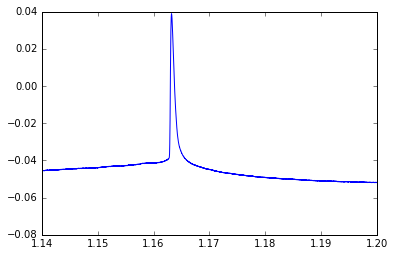

In [72]:
plt.plot(np.arange(0,len(response))/sampling_rate,response)
plt.xlim(1.14,1.2)
print peak_t

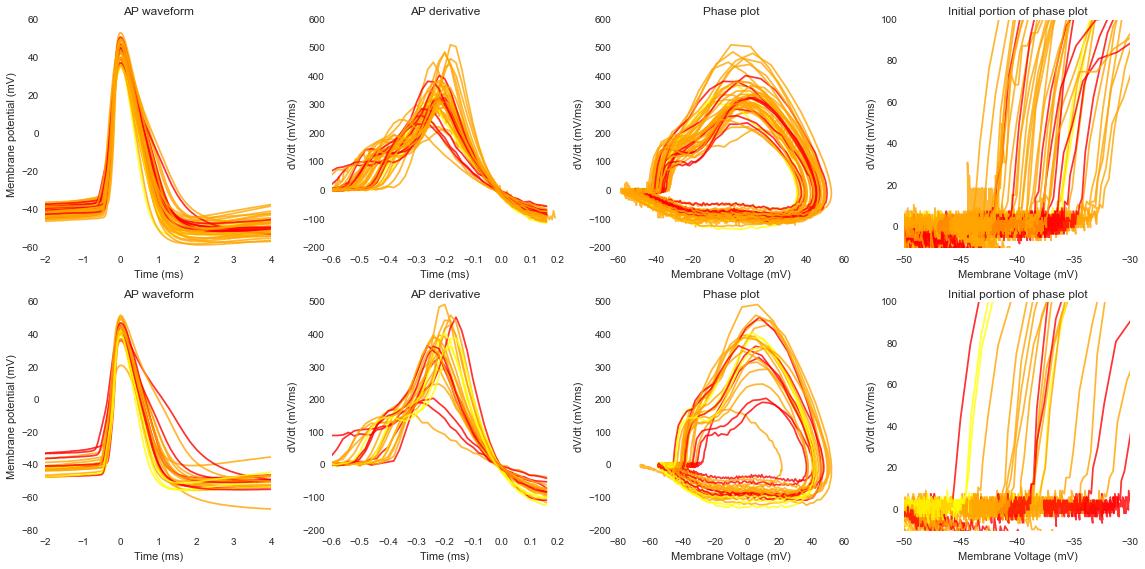

In [152]:
#what does the apical dendrite have to do with anything?

import scipy.signal as signal
fig,axes = plt.subplots(2,4,figsize = (16,8))
for i in range(len(human_df)):
    if human_df['dendrite_type'].iloc[i] == 'spiny':
        file_name = human_df['nwb_path'].iloc[i]
        data_set = NwbDataSet(file_name)
        sweep_data = data_set.get_sweep(human_df['hero_sweep'].iloc[i])
        sampling_rate = sweep_data['sampling_rate']
        response = sweep_data['response']

        if human_df['hero_rate'].iloc[i] == 1:
            freq = 1
        if human_df['hero_rate'].iloc[i] >1 and human_df['hero_rate'].iloc[i] < 15:
            freq = 2
        if human_df['hero_rate'].iloc[i] >= 15:
            freq = 3
        dendrite = human_df['dendrite_type'].iloc[i]
        dendrite_type = human_df['Truncation'].iloc[i]
        if dendrite_type == 'apical - intact':
            j = 0
        if dendrite_type == 'apical - truncated':
            j = 1
        if dendrite_type == 'apical - truncated?':
            pass


        peak_t = human_df['hero_ap_peak_t'].iloc[i]
        spike_times = data_set.get_spike_times(human_df['hero_sweep'].iloc[i])

        #AP Waveform
        start = (peak_t - .002) * sampling_rate
        end = (peak_t + .004) * sampling_rate
        ap_wave = response[start:end]
        axes[j,0].plot(np.arange(-(len(ap_wave)/3),2*len(ap_wave)/3)*1000/sampling_rate,ap_wave*1000,color = freq_color[dendrite][freq], alpha = .8)
        axes[j,0].set_xlabel('Time (ms)')
        axes[j,0].set_ylabel('Membrane potential (mV)')
        axes[j,0].set_title('AP waveform')

        #AP derivative
        N = 4
        Wn = .1

        B,A = signal.butter(N, Wn, output = 'ba')

        peak_t = human_df['hero_ap_peak_t'].iloc[i]
        ap_deriv = response[(peak_t-.0006)*sampling_rate:(peak_t+.0002)*sampling_rate]

        dv = np.diff(ap_deriv)
        dv_f = signal.filtfilt(B,A,dv)
        #plt.plot(np.arange(0,len(ap_deriv)-1),dv*sampling_rate,color = 'black')
        axes[j,1].plot(np.arange(-(len(ap_deriv)*3/4),len(ap_deriv)/4-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color[dendrite][freq], alpha = .8)

        #axes[1].plot(np.arange(0,len(ap_deriv)-1)*1000/sampling_rate,dv*sampling_rate,color = freq_color[freq], alpha = .6)
        axes[j,1].set_xlabel('Time (ms)')
        axes[j,1].set_ylabel('dV/dt (mV/ms)')
        axes[j,1].set_title('AP derivative')

        #Phase plot
        phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
        dv = np.diff(phase_plot)
        dv_f = signal.filtfilt(B,A,dv)
        axes[j,2].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color[dendrite][freq], alpha = .8)
        #plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
        axes[j,2].set_xlabel('Membrane Voltage (mV)')
        axes[j,2].set_ylabel('dV/dt (mV/ms)')
        axes[j,2].set_title('Phase plot')

        #Inital portion of phase plot
        phase_plot = response[(spike_times[0]-.004)*sampling_rate:(spike_times[0]+.004)*sampling_rate]
        dv = np.diff(phase_plot)
        dv_f = signal.filtfilt(B,A,dv)
        axes[j,3].plot(phase_plot[:-1]*1000,dv*sampling_rate, color = freq_color[dendrite][freq], alpha = .8)
        #plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
        axes[j,3].set_xlabel('Membrane Voltage (mV)')
        axes[j,3].set_ylabel('dV/dt (mV/ms)')
        axes[j,3].set_title('Initial portion of phase plot')
        axes[j,3].set_xlim(-50,-30)
        axes[j,3].set_ylim(-10,100)

    
    plt.tight_layout()

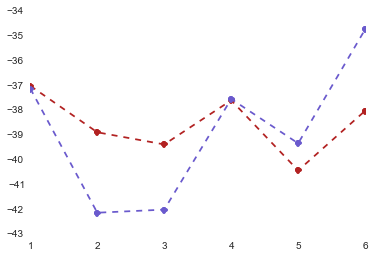

In [149]:
y1 = [] 
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] == 1) & (human_df['dendrite_type'] == 'spiny')]))
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 1) & (human_df['hero_rate'] <= 5) & (human_df['dendrite_type'] == 'spiny')]))
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 5) & (human_df['hero_rate'] <= 10) & (human_df['dendrite_type'] == 'spiny')]))
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 10) & (human_df['hero_rate'] <= 15) & (human_df['dendrite_type'] == 'spiny')]))
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 15) & (human_df['hero_rate'] <= 20) & (human_df['dendrite_type'] == 'spiny')]))
y1.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 20) & (human_df['hero_rate'] <= 25) & (human_df['dendrite_type'] == 'spiny')]))

y2 = [] 
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] == 1) & (human_df['dendrite_type'] == 'aspiny')]))
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 1) & (human_df['hero_rate'] <= 5) & (human_df['dendrite_type'] == 'aspiny')]))
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 5) & (human_df['hero_rate'] <= 10) & (human_df['dendrite_type'] == 'aspiny')]))
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 10) & (human_df['hero_rate'] <= 15) & (human_df['dendrite_type'] == 'aspiny')]))
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 15) & (human_df['hero_rate'] <= 20) & (human_df['dendrite_type'] == 'aspiny')]))
y2.append(np.mean(human_df['hero_ap_threshold_v'][(human_df['hero_rate'] > 20) & (human_df['hero_rate'] <= 25) & (human_df['dendrite_type'] == 'aspiny')]))

#print np.std(human_df['v_rest'][human_df['hero_rate'] == 1])
#print y

plt.plot(np.arange(1,len(y1)+1),y1,linestyle ='--', marker = 'o', color = 'firebrick')
plt.plot(np.arange(1,len(y2)+1),y2,linestyle ='--', marker = 'o', color = 'slateblue')


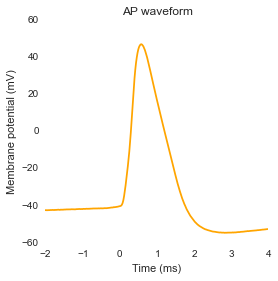

In [253]:
spike_times = data_set.get_spike_times(human_df['hero_sweep'].iloc[0])
start = (spike_times[0]-.002) * sampling_rate
end = (spike_times[0]+.004) * sampling_rate
ap_wave = response[start:end]
plt.figure(figsize=(4,4))
plt.plot(np.arange(-(len(ap_wave)/3),2*len(ap_wave)/3)*1000/sampling_rate,ap_wave*1000,color = freq_color[freq])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('AP waveform')

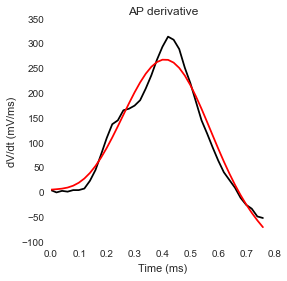

In [241]:
import scipy.signal as signal
N = 4
Wn = .1

B,A = signal.butter(N, Wn, output = 'ba')

ap_deriv = response[(spike_times[0]-.0001)*sampling_rate:(spike_times[0]+.0007)*sampling_rate]

dv = np.diff(ap_deriv)
dv_f = signal.filtfilt(B,A,dv)

plt.figure(figsize=(4,4))
plt.plot(np.arange(0,len(ap_deriv)-1)*1000/sampling_rate,dv*sampling_rate,color = 'black')
plt.plot(np.arange(0,len(ap_deriv)-1)*1000/sampling_rate,dv_f*sampling_rate,color = 'red')

plt.xlabel('Time (ms)')
plt.ylabel('dV/dt (mV/ms)')
plt.title('AP derivative')

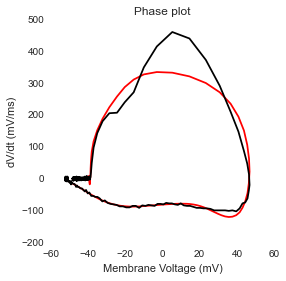

In [60]:
import scipy.signal as signal
N = 4
Wn = .1

B,A = signal.butter(N, Wn, output = 'ba')

phase_plot = response[(spike_times[0]-.01)*sampling_rate:(spike_times[0]+.01)*sampling_rate]
dv = np.diff(phase_plot)
dv_f = signal.filtfilt(B,A,dv)


plt.figure(figsize=(4,4))
plt.plot(phase_plot[:-1]*1000,dv_f*sampling_rate, color = 'red')
plt.plot(phase_plot[:-1]*1000,dv*sampling_rate, color = 'black')
plt.xlabel('Membrane Voltage (mV)')
plt.ylabel('dV/dt (mV/ms)')
plt.title('Phase plot')

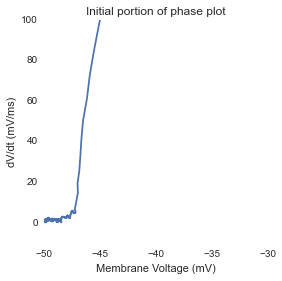

In [182]:
plt.figure(figsize=(4,4))
plt.plot(phase_plot[:-1]*1000,dv_f*sampling_rate)
plt.xlabel('Membrane Voltage (mV)')
plt.xlim(-50,-30)
plt.ylim(-10,100)
plt.ylabel('dV/dt (mV/ms)')
plt.title('Initial portion of phase plot')

In [82]:
import scipy.signal as signal
dt = len(response_test)
window = 0.005 # seconds
n_window_points = int(window / dt)


dv = np.gradient(response_test)

N = 4
Wn = 0.1
B,A = signal.butter(N, Wn, output = 'ba')

dv_f = signal.filtfilt(B,A,dv)

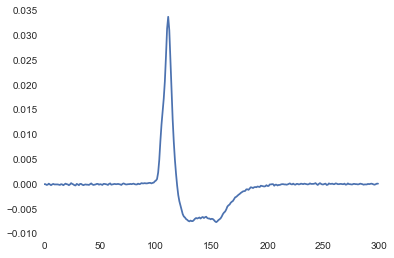

In [86]:
plt.plot(np.arange(0,len(response_test)),dv/dt*1000)

In [84]:
print len(dv)
print len(response_test)

300
300
